
# Intro to Neural Networks for Regression
Course: ITCS 4156 - Introduction to Machine Learning 

Instructor: Xiang Zhang

$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\uv}{\mathbf{u}}
 \newcommand{\vv}{\mathbf{v}}
 \newcommand{\tv}{\mathbf{t}}
 \newcommand{\bv}{\mathbf{b}}
 \newcommand{\av}{\mathbf{a}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Ym}{\mathbf{Y}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Wm}{\mathbf{W}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Im}{\mathbf{I}}
 \newcommand{\Um}{\mathbf{U}}
 \newcommand{\Vm}{\mathbf{V}}
 \newcommand{\Am}{\mathbf{A}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\Lambdav}{\boldsymbol\Lambda}
$

<br/>
<font color="blue"><b>

NAME: *enter your name here*

</b> </font>

## Goal 
The goal of this lab will be to practice implementing the feed-forward and feedback processes used by neural networks. We'll also take a look at manual hyper-parameter tuning. We'll do so by, once again, working with the Forest Fire dataset as we have already performed data exploration and preparation so that we can get to implementing neural networks more quickly.

Your job is to read through the lab and fill in any code segments that are marked by `TODO` headers and comments. **It should be noted, that all the correct outputs are given below each code cell. It might be useful to duplicate all the `TODO` cells so you can try to match the correct output with your own code!**

Use the `todo_check()`to help guide you in understanding whether your code for a given TODO is correct or incorrect. However, failing a TODO check doesn't mean you won't receive points, though it could be a good indication. If you are failing feel free to ask and we can help check what is happening.

## Agenda
- Review and load the Forest Fires dataset
- Visualize and explore the Forest Fires dataset
- Create the data preparation pipeline where we apply data preprocessing AFTER splitting
- Implement a simple 2 layer neural network
    - Implement identity/linear, sigmoid, and tanh activation functions.
    - Implement the neural network feed-forward process for making predictions
    - Implement the neural network feedback process for updating the weights and biases
- Investigate model tuning by manually turning hyper-parameters

## Table of notation

| Symbol                     | Meaning                     | Symbol    | Meaning                                                          |
|----------------------------|-----------------------------|-----------|------------------------------------------------------------------|
| $\xv$ or $\vec{x}$         | feature/input vector        | $x_i$     | $i$th element of $\xv$                                           |
| $\Xm$                      | input matrix                | $x_{i,j}$ | $i$th row and $j$th column of $\Xm$                              |
| $\yv$ or $\tv$             | labels/targets              | $n$       | number of features or columns 
| $\wv$ or $\mathbf{\theta}$ | weight/parameter vector     | $m$       | number of data samples <br>(also used to refer to the slope) |samples or rows                                   |
| $f$ or $h$                 | hypothesis function <br> (i.e., a model)        | $\hat{\yv}$ <br> $f(\xv {;} \wv)$<br>$h(\xv {;} \wv)$ | predictions <br> y-hat |
| $E$              | error or sum of error (loss)  | $SSE$      | sum of squared error function                                            |
| $MSE$                      | mean squared error| $\nabla$  | gradient (nabla)                                       |
| $\partial$                 | partial derivative          | $\alpha$  | learning rate (alpha)                                  |       
| $J$ | general placeholder for <br>the objective function | $x^T$| transpose of a vector or matrix |
$b$ | bias or y-intercept term | $T$ | Threshold |
$*$| element-wise<br> multiplication | $\cdot$ | dot product|
| $z$<br>$\zv$| value before applying activation function |  $X, Y$ | Random variables |
| $K$| number/set of classes | $k$ | current class|
| $MLE$|  maximum likelihood estimation | $ML$ |  maximum likelihood|
| $MLL$|  maximum log likelihood | $LL$ | log likelihood |
| $L$|  likelihood | $NLL$ | negative log likelihood |
| $g$ | activation function | $a$/$h$ <br> $\av/\mathbf{h}$<br>$\Am$/$\mathbf{H}$ | output of activation function <br> or neuron
$w$<br>$\wv$<br>$\Wm$ | weights| $z$<br>$\zv$<br>$\Zm$ | linear combination output|
|$\Wm^{[l]}$| $l$th layer weights| $\Am^{[l]}$| $l$th layer activations
|$\Zm^{[l]}$| $l$th layer linear combinations| $\bv^{[l]}$| $l$th layer bias

## Imports

In [ ]:
import os
import warnings
import gc
from typing import Tuple, Union, List, Dict

import sklearn
sklearn_version = '1.0'
# Check to make sure you have the right version of sklearn
assert sklearn.__version__  > sklearn_version, f'sklearn version is only {sklearn.__version__} and needs to be > {sklearn_version}'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

np.set_printoptions(suppress=True) 
%matplotlib inline

In [ ]:
# Set this to True if you DO NOT want to run the 
# garbage_collect() functions throughout the notebook
turn_off_garbage_collect = False

def garbage_collect(vars_):
    if not turn_off_garbage_collect:
        for v in vars_:
            if v in globals():
                del globals()[v]
        collected = gc.collect()

def todo_check(condi_err):
    failed_err = "You passed {}/{} and FAILED the following code checks:{}"
    failed = ""
    n_failed = 0
    for check, (condi, err) in enumerate(condi_err):
        if not condi:
            n_failed += 1
            failed += f"\nFailed check [{check+1}]:\n\t Tip: {err}"

    if len(failed) != 0:
        passed = len(condi_err) - n_failed
        err = failed_err.format(passed, len(condi_err), failed)
        raise AssertionError(err.format(failed))
    print("Your code PASSED the code check!")

# Problem statement summary and data loading

![](https://fee.org/media/38322/forest-fire-3782544_1280.jpg?anchor=center&mode=crop&height=656&widthratio=2.1341463414634146341463414634&rnd=132451547710000000)

### Problem statement summary

Recall that our goal here is to help prevent and make firefighting easier by identifying "high risk" areas by predicting how much area of a forest could burn when a fire occurs. We are attempting to achieve this by using supervised learning where our labels corresponds to the amount of forest area (in hectares) that has burned in the past.

### Data loading

To begin, let's fetch the Forest Fire dataset. If you don't have it then download it using the following link: https://archive.ics.uci.edu/ml/datasets/Forest+Fires. When you arrive at the UCI webite click the "Data Folder" button near the top right to download the dataset. Once clicked, download the following file: `forestfires.csv`.

Be sure to move the `forestfires.csv` file to the **SAME** directory/folder that this Jupyter Notebook is in (i.e., the current path of the notebook). We need to do this so that when we go to load the data we can easily path to the files! Run the below code to check which will print your notebook's current path and which directory the notebook is in!

In [ ]:
print(f"The current path for your notebook is:\n {os.getcwd()}\n")
print(f"Your notebook is currently in the following directory:\n {os.path.basename(os.getcwd())}")

The current path for your notebook is:
 /home/dev/mnt/4156/modules/module-9-nn-nonlinear-regression

Your notebook is currently in the following directory:
 module-9-nn-nonlinear-regression


#### TODO 1
Complete the TODO by loading the `forestfires.csv`.

1. Load Forest Fires dataset using the Pandas. Store the output into the `forestfire_df` variable.

In [ ]:
# This line checks to make sure the forestfire.csv is in the 
# same directory as this notebook.
if not os.path.exists("forestfires.csv"):
    warnings.warn(f"The forestfires.csv is not detected in your local path! " \
                    f"You need to move the 'forestfires.csv' file to the same " \
                    f"location/directory as this notebook which is {os.getcwd()}")   
# TODO 1.1
forestfire_df = 
forestfire_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Visualization and exploration

Now, we have already done most of the visualization and data exploration in prior labs. However, let's start by reviewing some of the ideas we learned while exploring the data.

## Observing linear and non-linear trends

First, let's review how each one of our features correlates with our target 'area'. Recall, we have take the log of our target 'area' in order to spread out the skewed distribution towards being more normal. Below, is the code from previous labs for plotting our target 'area' against every input feature. 

Once again, take note that none of our features, when compared 1-1 with our target, seem to show a linear or non-linear trend.

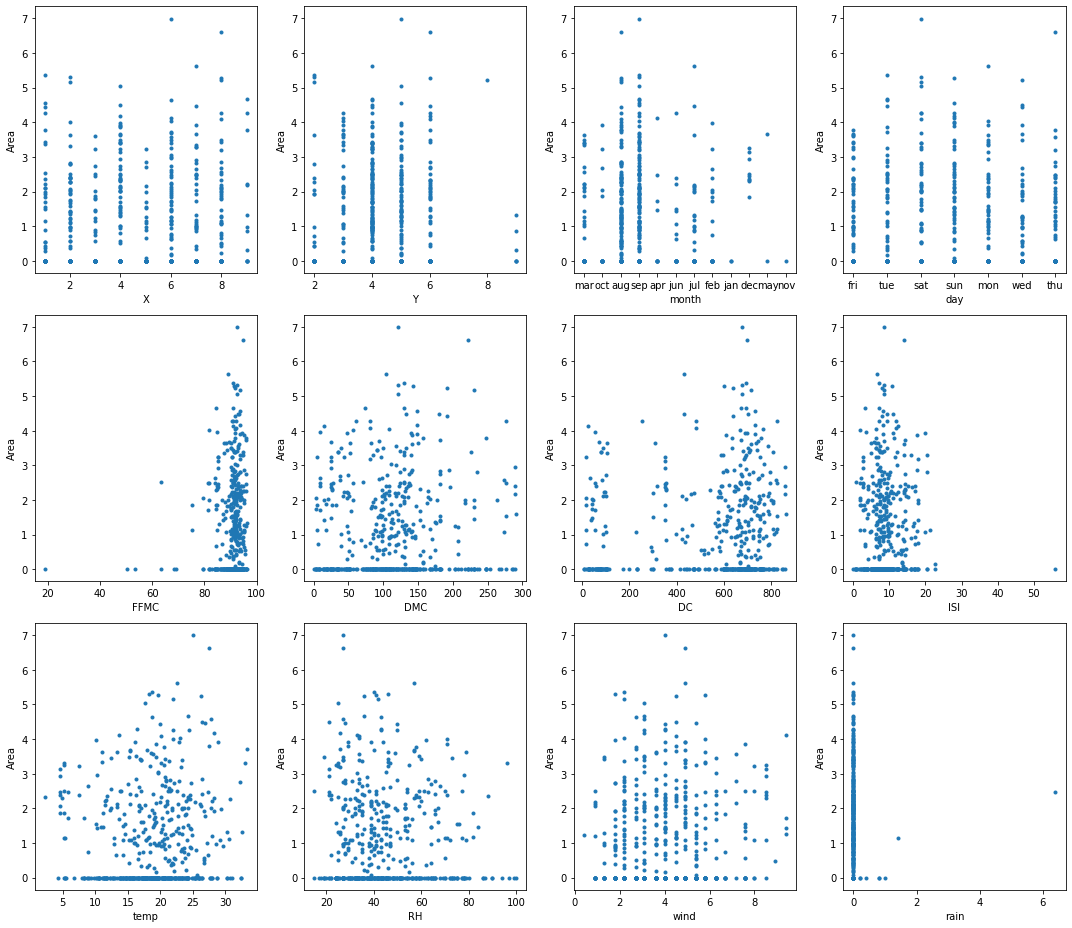

In [ ]:
log_area_values = np.log1p(forestfire_df['area'])
features = forestfire_df.drop('area', axis=1)

fig, _ = plt.subplots(figsize=(15, 13))

# column_name holds the current column name
# idx holds the current column index
# You can use either to index features to get the current feature
for idx, column_name in enumerate(features.columns.values):
    plt.subplot(3, 4, idx+1)
    plt.plot(features[column_name], log_area_values, '.')
    plt.ylabel('Area')
    plt.xlabel(column_name)
fig.tight_layout()
plt.show()

# Data Preparation Pipeline

Now it's time to recreate our data preparation pipelines we used in prior weeks. In this lab we will, once again, apply all our data cleaning and transformation operations AFTER splitting the data since the data is technically partly split already. 

## Dropping outliers
Recall, before we do anything, we need to remove any extreme outliers that might distort the performance of our model. Below we define a function for you for dropping outliers that we used in prior labs.

In [ ]:
from scipy.stats import zscore

def outlier_locations(z, threshold):
    abs_z = np.abs(z)
    outlier_locs = np.where(abs_z > threshold)
    return outlier_locs[0]

def drop_outliers(df, threshold, verbose=False):
    numerical_cols_df = df.drop(['day', 'month', 'area'], axis=1)
    # Get z-scores
    z = numerical_cols_df.apply(zscore)

    # Find outlier locations
    outlier_locs = outlier_locations(z, threshold=threshold)
    
    # Drop samples
    new_df = df.drop(outlier_locs, axis=0)
    
    if verbose:
        print("Dropping...")
        print(f"forestfire_df BEFORE dropping: {forestfire_df.shape}")
        print(f"forestfire_df AFTER dropping: {new_df.shape}")
        display(df.iloc[outlier_locs])

    return new_df

Below, the `TEST_drop_outliers()` function provides example code for running the `drop_outliers()` function. Notice, using a threshold of 5 removes any data sample whose feature values are greater than 5 standard deviations above or below the feature mean.

In [ ]:
def TEST_drop_outliers():

    dropped_forestfire_df = drop_outliers(
        forestfire_df, 
        threshold=5, 
        verbose=True
    )
    
TEST_drop_outliers()
garbage_collect(['TEST_drop_outliers'])    

Dropping...
forestfire_df BEFORE dropping: (517, 13)
forestfire_df AFTER dropping: (512, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
22,7,4,jun,sun,94.3,96.3,200.0,56.1,21.0,44,4.5,0.0,0.00
299,6,5,jun,sat,53.4,71.0,233.8,0.4,10.6,90,2.7,0.0,0.00
312,2,4,sep,sun,50.4,46.2,706.6,0.4,12.2,78,6.3,0.0,0.00
379,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0.0,0.00
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82


## Splitting data

Now onto splitting! Below we redefine the splitting functions `feature_label_split()` and `train_valid_test_split()` which we have seen in prior labs.

In [ ]:
def feature_label_split(df: pd.DataFrame, 
                        label_name: str) -> Tuple[pd.DataFrame]:
    """ Split dataframe into features and labels
    
        Args:
            df: DataFrame containing both features and labels
            
            label_name: Name of the column which contains the labels
    """
    
    X = df.drop(label_name, axis=1)
    y = df[[label_name]].copy()
    
    return X, y

Below, within the `TEST_feature_label_split()` function is an example of how to call the `feature_label_split()` function.

In [ ]:
def TEST_feature_label_split():
    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df, label_name='area')

    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
TEST_feature_label_split()
garbage_collect(['TEST_feature_label_split'])

X shape: (512, 12)
y shape: (512, 1)


In [ ]:
from sklearn.model_selection import train_test_split

def train_valid_test_split(
    X: pd.DataFrame, 
    y: pd.DataFrame, 
    seed: int = 42
) -> Tuple[pd.DataFrame]:
    """ Split data into trining, validation, and test sets
        
        Args:
            X: Features typically given as a Panda's DataFrame
            
            y: Targets/labels typically given as a Panda's DataFrame
            
            seed: Seed to create reproducible validation and testing splits
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=.2, random_state=seed)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=.2, random_state=seed)
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

Below, within the `TEST_train_valid_test_split()` function is an example of how to call the `train_valid_test_split()` function.

In [ ]:
def TEST_train_valid_test_split():
    
    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df, label_name='area')
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)

    print(f"X_trn shape: {X_trn.shape}")
    print(f"y_trn shape: {y_trn.shape}")
    print(f"X_vld shape: {X_vld.shape}")
    print(f"y_vld shape: {y_vld.shape}")
    print(f"X_tst shape: {X_tst.shape}")
    print(f"y_tst shape: {y_tst.shape}")

TEST_train_valid_test_split()
garbage_collect(['TEST_train_valid_test_split'])

X_trn shape: (327, 12)
y_trn shape: (327, 1)
X_vld shape: (82, 12)
y_vld shape: (82, 1)
X_tst shape: (103, 12)
y_tst shape: (103, 1)


## Transforming and cleaning data

This module's data cleaning will contain nothing new. As we are working with the Forest Fire dataset we'll apply the `LogTransformer`class to the targets while applying `OneHotEncoding` and `Standardization` classes to the features. Keep in mind, we'll also be using Sklearn's `ColumnTransformer` and our own `DataFrameColumnTransformer` which applies Sklearn's `ColumnTransformer`  but returns the output as a DataFrame.

If you get lost be sure to reference the regression labs from early in the semester for help!

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### DataFrameColumnTransformer

Below we redefine our `DataFrameColumnTransformer` which we'll need when conducting feature preprocessing. Remember, this class acts just like Sklearn's `ColumnTransformer` which will only apply certain preprocessing steps to certain columns in our DataFrame. The difference is that the output of our `DataFrameColumnTransformer` will be DataFrame and not a NumPy array.

In [ ]:
class DataFrameColumnTransformer(TransformerMixin):
    def __init__(self, stages: List[Tuple]):
        self.col_trans = ColumnTransformer(stages, remainder='passthrough')
    
    def fit(self, X: pd.DataFrame):
        """ Runs our ColumnTransformer.fit() method """
        self.col_trans.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """ Runs our ColumnTransformer.transform() method """
        output_arr = self.col_trans.transform(X)
        
        return self.to_dataframe(output_arr)
    
    def to_dataframe(self, arr: np.ndarray) -> pd.DataFrame:
        """Converts our output of ColumnTransformer into a DataFrame"""
        feature_names = self.col_trans.get_feature_names_out()
        
        # Remove the "__" that ColumnTransformer adds to our feature names
        # when we call self.col_trans.get_feature_names_out()
        for i, name in enumerate(feature_names):
            if '__' in name:
                feature_names[i] = name.split('__', 1)[-1]
        
        # Creates a Pandas Dataframe
        df = pd.DataFrame(arr, columns=feature_names)
        return df

### Target cleaning

The only preprocessing steps for our targets will be to apply the log transform using the `LogTransformer` class. Recall that we do this in an attempt to make the target values less of a skewed distribution by using the log transform to help spread out the values.

In [ ]:
class LogTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.feature_names = None
    
    def fit(self, y: pd.DataFrame):
        
        # We don't need to set/learn any variables so
        # we just need to return a reference to the object with 'self'
        # If we dont return self the Pipeline class will throw errors
        return self
    
    def transform(self, y: pd.DataFrame) -> pd.DataFrame:
        self.feature_names = y.columns
        
        return np.log1p(y)
    
    def get_feature_names_out(self, name=None) -> pd.Series:
        return self.feature_names

#### TODO 2

Complete the TODO by coding the `target_pipeline()` function.

1. Complete the `target_pipeline()` function as follows: 
    1. Define an instance of Sklearn's `Pipeline` class which applies the `LogTransformer` class. 

    2. Fit and transform the training labels `y_trn`.

    3. Transform the validation labels `y_vld`. 

    4. Transform the test labels `y_tst`.

    5.  Return the cleaned output for training, validation, and testing labels. The order of returned values should be training, validation, and then testing.


In [ ]:
# TODO 2.1
def target_pipeline(y_trn, y_vld, y_tst):
    """ Creates Pipeline to apply data cleaning and transformations 
        to the targets/labels.
        
        Args:
            y_trn: train labels
            
            y_vld: validation labels
            
            y_tst: test labels
    """
    pass # Replace this line with your code


Run the below `TEST_target_pipeline()` function to test your implementation of the `target_pipeline()` function.

In [ ]:
def TEST_target_pipeline():
    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df, label_name='area')
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)
    # Apply  data cleaning and transformations
    y_trn, y_vld, y_tst = target_pipeline(y_trn, y_vld, y_tst)

    print(f"y_trn shape: {y_trn.shape}")
    print(f"y_trn type: {type(y_trn)}")
    print(f"y_vld shape: {y_vld.shape}")
    print(f"y_vld type: {type(y_vld)}")
    print(f"y_tst shape: {y_tst.shape}")
    print(f"y_tst type: {type(y_tst)}")

    todo_check([
        (np.all(np.isclose(y_trn.iloc[:3].values.reshape(-1,), [0, 1.854734, 2.833213], rtol=.01)),'y_trn possibly contains incorrect values'),
        (np.all(np.isclose(y_vld.iloc[:3].values.reshape(-1,), [0, 2.489894, 1.435085], rtol=.01)), 'y_vld possibly contains incorrect values'),
        (np.all(np.isclose(y_tst.iloc[:3].values.reshape(-1,), [0.343590, 0, 0], rtol=.01)), 'y_tst possibly contains incorrect values')
    ])

TEST_target_pipeline()
garbage_collect(['TEST_target_pipeline'])

y_trn shape: (327, 1)
y_trn type: <class 'pandas.core.frame.DataFrame'>
y_vld shape: (82, 1)
y_vld type: <class 'pandas.core.frame.DataFrame'>
y_tst shape: (103, 1)
y_tst type: <class 'pandas.core.frame.DataFrame'>
Your code PASSED the code check!


### Feature cleaning

The only feature cleaning classes we'll need is our `OneHotEncoding` and `Standardization` classes which we redefine for you below. 

**Notice we have NO `AddBias` class!** Although the bias term is still required, for neural networks we'll treat the bias as a separate term which we can optimize for directly for the sake of clarity. This means we don't need to add a column of 1s to our data as, once again, the bias will be treated separately from the weights!

In [ ]:
from sklearn.preprocessing import OneHotEncoder

class OneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names='auto'):
        self.feature_names = feature_names
        self.encoder = OneHotEncoder(categories=feature_names, sparse=False)

    def fit(self, X: pd.DataFrame):
        
        self.encoder.fit(X)
        
        # Store names of features
        self.feature_names = self.encoder.get_feature_names_out()
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        
        one_hot =  self.encoder.transform(X)

        return pd.DataFrame(one_hot, columns=self.get_feature_names_out())
    
    def get_feature_names_out(self, name=None)-> pd.Series:
        return self.feature_names

In [ ]:
class Standardization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None
    
    def fit(self, X: pd.DataFrame) -> pd.DataFrame:
        
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        self.feature_names = X.columns
        return (X  - self.mean) / self.std

    def get_feature_names_out(self, name=None) -> pd.Series:
        return self.feature_names

#### TODO 3
Complete the TODO by coding the `feature_pipeline()` function.

1. Define the `feature_pipeline()` function as follows:
    1. First, declare an instance of `DataFrameColumnTransformer` which applies the `OneHotEncoding()` class to the ONLY the "day" and "month" features. 
    
    2. Now, declare an instance of the Sklearn's `Pipeline` class which is a list of tuples. The 1st tuple should apply your `DataFrameColumnTransformer`  instance and the 2nd tuple should apply an instance of the `Standardization()` class.
    
    3. Fit and transform the training data `X_trn` using your `Pipeline` class instance.

    4. Transform the validation data `X_vld` using your `Pipeline` class instance.

    5. Transform the test data `X_tst` using your `Pipeline` class instance.

    6.  Return the cleaned output for training, validation, and testing data. The order of returned values should be training, validation, and then testing.

In [ ]:
# TODO 3.1
def feature_pipeline(X_trn: pd.DataFrame, 
                     X_vld: pd.DataFrame, 
                     X_tst: pd.DataFrame) -> List[pd.DataFrame]:
    """ Creates column transformers and pipelines to apply data clean and 
        transfornations to the input features of our data.
        
        Args:
            X_trn: train features
            
            X_vld: validation features
            
            X_tst: test features
    """
    pass # Replace this line with your code

Run the below `TEST_feature_pipeline()` function to check you implementation of the `feature_pipeline()` class.

In [ ]:
def TEST_feature_pipeline(): 
    
    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df, label_name='area')
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)

    X_trn, X_vld, X_tst = feature_pipeline(X_trn, X_vld, X_tst)
    print(X_tst.iloc[:3, 5].values)
    print(f"X_trn shape: {X_trn.shape}")
    print(f"X_trn type: {type(X_trn)}")
    print(f"X_vld shape: {X_vld.shape}")
    print(f"X_vld type: {type(X_vld)}")
    print(f"X_tst shape: {X_tst.shape}")
    print(f"X_tst type: {type(X_tst)}")
    display(X_trn)

    todo_check([
        (X_trn.shape[1] == 29, "X_trn does not have enough columns"),
        ('day_fri' in X_trn.columns, "X_trn is missing one-hot encoded columns"),
        ('month_apr' in X_vld.columns, "X_vld is missing one-hot encoded columns"),
        ('day_thu' in X_tst.columns, "X_tst is missing one-hot encoded columns"),
        (np.all(np.isclose(X_trn.iloc[:3, 5], [-0.37862467,  2.64113797, -0.37862467], rtol=.01)), "X_trn possibly contains incorrect values!"),
        (np.all(np.isclose(X_vld.iloc[:3, 5], [ 2.64113797, -0.37862467, -0.37862467], rtol=.01)), "X_vld possibly contains incorrect values!"),
        (np.all(np.isclose(X_tst.iloc[:3, 5], [-0.37862467,  2.64113797, -0.37862467], rtol=.01)), "X_tst possibly contains incorrect values!"),
    ])
    
TEST_feature_pipeline()
garbage_collect(['TEST_feature_pipeline'])

[-0.37862467  2.64113797 -0.37862467]
X_trn shape: (327, 29)
X_trn type: <class 'pandas.core.frame.DataFrame'>
X_vld shape: (82, 29)
X_vld type: <class 'pandas.core.frame.DataFrame'>
X_tst shape: (103, 29)
X_tst type: <class 'pandas.core.frame.DataFrame'>


,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,month_apr,month_aug,month_dec,...,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-0.439808,-0.399468,-0.439808,-0.474045,2.678619,-0.378625,-0.346212,-0.124611,-0.776493,-0.136717,...,0.986994,-0.250217,-0.307653,2.642035,1.205984,-0.538765,0.112289,-0.001283,-0.253254,-0.085642
1,-0.439808,-0.399468,-0.439808,-0.474045,-0.373327,2.641138,-0.346212,-0.124611,-0.776493,-0.136717,...,0.556665,0.551948,-3.997167,-1.626181,-2.077810,-1.782123,-2.368005,2.216283,1.278240,-0.085642
2,-0.439808,-0.399468,-0.439808,2.109502,-0.373327,-0.378625,-0.346212,-0.124611,1.287842,-0.136717,...,-1.164653,-0.250217,0.172490,1.043718,0.274571,-0.335768,0.363670,0.298388,-1.047362,-0.085642
3,-0.439808,-0.399468,-0.439808,-0.474045,-0.373327,-0.378625,2.888400,-0.124611,1.287842,-0.136717,...,-1.164653,-0.250217,0.324113,-0.310097,-0.156646,0.171725,0.330152,1.497072,-1.047362,-0.085642
4,-0.439808,-0.399468,-0.439808,2.109502,-0.373327,-0.378625,-0.346212,-0.124611,-0.776493,7.314369,...,-0.303994,1.354113,-1.646997,-1.282067,-0.748289,-0.538765,-2.334487,0.717928,2.526124,-0.085642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,2.273722,-0.399468,-0.439808,-0.474045,-0.373327,-0.378625,-0.346212,-0.124611,-0.776493,-0.136717,...,0.986994,-0.250217,-1.596456,-1.644292,-1.969809,-1.426878,-1.764690,0.478191,3.036622,-0.085642
323,-0.439808,-0.399468,-0.439808,-0.474045,-0.373327,2.641138,-0.346212,-0.124611,1.287842,-0.136717,...,-1.594983,-1.854546,0.981150,-0.058049,0.408981,2.049449,-0.021781,0.358322,0.257244,-0.085642
324,-0.439808,2.503331,-0.439808,-0.474045,-0.373327,-0.378625,-0.346212,-0.124611,-0.776493,-0.136717,...,-0.303994,-0.250217,-0.939419,-1.331873,-1.886640,-1.223881,-1.161375,-0.600625,-1.274250,-0.085642
325,-0.439808,-0.399468,2.273722,-0.474045,-0.373327,-0.378625,-0.346212,-0.124611,-0.776493,-0.136717,...,0.556665,0.551948,0.197760,-1.152270,-1.823179,-0.285019,-0.222886,-1.199967,0.484132,-0.085642


Your code PASSED the code check!


## Putting it all together

In order to make our lives easier we created a function called `data_prep()` which will apply the outlier removal, data splitting, and data cleaning/transforming for us. Thus, whenever we go to implement a new algorithm we can call `data_prep()` to give us our data and override any other variables with the same names!

**Take time to also read the DocStrings or in-line documentation, given at the start of the function, which describes what each argument does. You need to understand what each argument does before moving forward!**

*Note: Any arguments in a function given after the `*` in the function definition below MUST be passed using the keyword. See this [post](https://stackoverflow.com/questions/14301967/bare-asterisk-in-function-arguments) for more information.*

In [ ]:
def data_prep(df: pd.DataFrame,
              label_name: str,
              *,
              seed: int = 42,
              return_array: bool = False,
              outlier_threshold: int = 5) -> Tuple[pd.DataFrame]:
    """ Removes outliers, splits data and runs target/feature data cleaning 
        and transformations.
    
        Args:
            df: A Pandas DataFrame containing our dataset for the 
                current lab.
                
            label_name: Name of the column in the DataFrame store in df 
                which will be used as the label/target. This will be 
                passed to the feature_label_split() function.
            
            seed: The seed used when splitting data into train, 
                validation, and test. This will be passed to the
                train_valid_test_split() function.
            
            return_array: A boolean which when True will return all data as NumPy
                arrays instead of Pandas DataFrames.
            
            outlier_threshold: outlier threshold where if a data sample exceeds
                the STD threshold for any given feature then it is dropped. This
                will be passed to the drop_outliers() function.
    """   
    # Drop outliers
    dropped_df = drop_outliers(df, threshold=outlier_threshold)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_df, label_name=label_name)
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y, seed)
    # Target cleaning
    y_trn, y_vld, y_tst = target_pipeline(y_trn, y_vld, y_tst)
    # Feature cleaning
    X_trn, X_vld, X_tst = feature_pipeline(X_trn, X_vld, X_tst)
    
    # Resets the Pandas index for the Dataframe and series
    # This will prevent any headaches when combining or indexing
    # the train, validation, and test data in the future.
    X_trn.reset_index(inplace=True, drop=True)
    y_trn.reset_index(inplace=True, drop=True)
    X_vld.reset_index(inplace=True, drop=True)
    y_vld.reset_index(inplace=True, drop=True)
    X_tst.reset_index(inplace=True, drop=True)
    y_tst.reset_index(inplace=True, drop=True)
        
    # Return data as arrays instead of DataFrames
    if return_array:
        X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = (X_trn.values, 
                                                    y_trn.values, 
                                                    X_vld.values, 
                                                    y_vld.values, 
                                                    X_tst.values, 
                                                    y_tst.values)
                               
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

#### TODO 4
Complete this TODO by calling `data_prep()` as specified below.


1. Call the `data_prep()` so that it will return the Forest Fire regression data formatted as NumPy arrays by passing the arguments which correspond to the following:
    1. Pass all required arguments for `df` and `label_name`.
    1. Return all data as NumPy arrays.

In [ ]:
def TEST_data_prep():
    # TODO 4.1
    data =
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data

    print(f"X_trn type: {type(X_trn)}")
    print(f"X_trn shape: {X_trn.shape}")
    print(f"y_trn shape: {y_trn.shape}")
    print(f"X_vld type: {type(X_vld)}")
    print(f"X_vld shape: {X_vld.shape}")
    print(f"y_vld shape: {y_vld.shape}")
    print(f"X_tst type: {type(X_tst)}")
    print(f"X_tst shape: {X_tst.shape}")
    print(f"y_tst shape: {y_tst.shape}")

    todo_check([
        (type(X_trn) is np.ndarray, "X_trn is not a NumPy array"),
        (np.all(np.isclose(y_trn[:3].flatten(), np.array([0., 1.85473427, 2.83321334]), rtol=.01)), "y_trn has incorrect values! Make sure the current column name was given to act as the labels!")
    ])
    
TEST_data_prep()
garbage_collect(['TEST_data_prep'])

X_trn type: <class 'numpy.ndarray'>
X_trn shape: (327, 29)
y_trn shape: (327, 1)
X_vld type: <class 'numpy.ndarray'>
X_vld shape: (82, 29)
y_vld shape: (82, 1)
X_tst type: <class 'numpy.ndarray'>
X_tst shape: (103, 29)
y_tst shape: (103, 1)
Your code PASSED the code check!


# Metrics and Plots

Like always, below are functions which will bes used to measure the model's performance, compute loss/cost values, and visualize any results.

#### TODO 5

Complete the following TODO by finishing the following performance metric functions: sum of squared error `sse()`, mean squared error `mse()`, and root mean square error `rmse()`.

1. Implement the sum of squared errors (SSE) cost function by finishing the `sse()` function. Store output into `sse_`.

$$
SSE  = \sum_{i=0}^m (\hat{y} - y)^2
$$ 

2. Implement the mean square error (MSE) loss function by finishing the `mse()` function. Store output into `mse_`.
$$
MSE  = \frac{1}{m}\sum_{i=0}^m (\hat{y} - y)^2
$$ 

3. Implement the root mean squared error (RMSE) loss function by finishing the `rmse()` function. Store output into `rmse_`.
$$
RMSE  = \sqrt{\frac{1}{m}\sum_{i=0}^m (\hat{y} - y)^2}
$$ 

In [ ]:
def reshape_labels(y):
    if len(y.shape) != 2:
        y = y.reshape(-1, 1)
    return y

def sse(y: np.ndarray, y_hat: np.ndarray):
    # Checks if y or y_hat need to be reshaped into 2D arrays
    y = reshape_labels(y)
    y_hat = reshape_labels(y_hat)
    
    # TODO 5.1
    
    return sse_

Run the below `TEST_sse` function to test your implementation of the `sse()` function.

In [ ]:
def TEST_sse():
    rng = np.random.RandomState(0)
    fake_y_hat = rng.rand(100, 1)
    fake_y = rng.rand(100, 1)
    
    sse_ = sse(y=fake_y, y_hat=fake_y_hat)
    print(f"Fake SSE: {sse_}")

    todo_check([
        (np.isclose(sse_, 17.328, rtol=.01), 'sse value is wrong!'),
    ])
    
TEST_sse()
garbage_collect(['TEST_sse'])

Fake SSE: 17.32899026015814
Your code PASSED the code check!


In [ ]:
def mse(y: np.ndarray, y_hat: np.ndarray):
    y = reshape_labels(y)
    y_hat = reshape_labels(y_hat)
    
    # TODO 5.2
    
    return mse_

Run the below `TEST_mse` function to test your implementation of the `mse()` function.

In [ ]:
def TEST_mse():
    rng = np.random.RandomState(0)
    fake_y_hat = rng.rand(100, 1)
    fake_y = rng.rand(100, 1)

    mse_ = mse(y=fake_y, y_hat=fake_y_hat)
    print(f"Fake MSE: {mse_}")

    todo_check([
        (np.isclose(mse_, 0.173, rtol=.01),'mse_ value is wrong!'),
    ])
    
TEST_mse()
garbage_collect(['TEST_mse'])

Fake MSE: 0.1732899026015814
Your code PASSED the code check!


In [ ]:
def rmse(y: np.ndarray, y_hat: np.ndarray):
    y = reshape_labels(y)
    y_hat = reshape_labels(y_hat)
    
    # TODO 5.3
    
    return rmse_

Run the below `TEST_rmse` function to test your implementation of the `rmse()` function.

In [ ]:
def TEST_rmse():
    rng = np.random.RandomState(0)
    fake_y_hat = rng.rand(100, 1)
    fake_y = rng.rand(100, 1)

    rmse_ = rmse(y=fake_y, y_hat=fake_y_hat)
    print(f"Fake RMSE: {rmse_}")

    todo_check([
        (np.isclose(rmse_, 0.416, rtol=.01), 'rmse_ value is wrong!'),
    ])
    
TEST_rmse()
garbage_collect(['TEST_rmse'])

Fake RMSE: 0.41628103800387234
Your code PASSED the code check!


Below we define the `unlog()` function for you. The equation $e^{x} -1$ is used for reversing the log transform. Recall we use this to undo the log transformation done to our target 'area'. Further, we use this function in conjunction with RMSE to get the average loss in the original units hectare (ha).

In [ ]:
def unlog(x):
    return np.exp(x) - 1

Next, we quickly define the `performance_measures()` function which will automatically compute the SSE, MSE, and RMSE using the functions you implemented above. 

In [ ]:
def performance_measures(y: np.ndarray, y_hat: np.ndarray) -> Tuple[np.ndarray]:   
    sse_ = sse(y=y, y_hat=y_hat)
    mse_ = mse(y=y, y_hat=y_hat)
    rmse_ = rmse(y=y, y_hat=y_hat)
    
    return sse_, mse_, rmse_

Lastly, we quickly define the function `analyze()` function which computes all the loss/cost function scores and plots our targets and predictions. 

There are two plots that we will use. The first simply plots the targets and predictions on top of each other while the second plots the targets against the predictions where the targets are on the y-axis and predictions are on the x-axis.

The second plot is a QQ plot (see below image). We use the QQ plot to plot the targets against the predictions. The diagonal line indicates the line of zero error. The closer each data point is to the line the lower the loss. Thus, the closer the prediction is to the actual target value. Good performance is indicated by the majority of the data points being close to the diagonal line.
<img src="https://miro.medium.com/max/384/1*pmqp-wtSjUgPHCBs1Mm7Xg.jpeg" width=300 height=300>


In [ ]:
def analyze(
    y: np.ndarray,
    y_hat: np.ndarray,  
    title: str, 
    dataset: str,
    xlabel: str = None,
    ylabel: str = None
) -> Tuple[np.ndarray, float, float, float]:
    """ Plot your results and compute perforamnce measures 
        using your predictions and labels.
        
        Args:
            y: Labels
            
            y_hat: Predictions
            
            title: Title of plot
            
            dataset: Name of dataset being plotted 
                (typically training, validaiton, or test).
                
            xlabel: X-axis label for the 1st plot
            
            ylabel - Y-axis label for both plots
    """
    y = reshape_labels(y)
    y_hat = reshape_labels(y_hat)
    
    sse_, mse_, rmse_ = performance_measures(y=y, y_hat=y_hat)
    
    # plotting
    fig, axs = plt.subplots(1, 2, figsize=(15,7))
    fig.suptitle(title, fontsize=15)
    axs[0].plot(y, 'ob', label='Target')
    axs[0].plot(y_hat, 'xr', label='Prediction')
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)
    axs[0].legend()

    y1 = min(y)
    y2 = max(y)
    line = np.arange(y1,y2)
    axs[1].scatter(y, y_hat, label="True vs Predicted", color='b', marker='*')
    axs[1].set_xlabel("Targets")
    axs[1].set_ylabel(ylabel)
    # axs[1].set_ylim(y1, y2)
    # axs[1].set_xlim(y1, y2)
    axs[1].plot(line, line, label = "Line of Zero Error", color='r')
    plt.legend()
    plt.show()
    
    print(f"{dataset} MSE: {mse_}")
    print(f"{dataset} RMSE: {rmse_}")
    print(f"{dataset} SSE: {sse_}\n")
    
    print(f"{dataset} unlogged MSE: {unlog(mse_)} ha")
    print(f"{dataset} unlogged RMSE: {unlog(rmse_)} ha")
    
    return sse_, mse_, rmse_

# Neural Networks
Let's get onto implementing the neural network algorithm. A short summary of neural networks will be given below. For more details see the notes.

A general neural network framework can be seen in the below image. The below neural network is an example of a 2 layer neural network. We'll be working with 2 layer neural networks throughout this lab. 


<img src="https://images.squarespace-cdn.com/content/v1/5ccb715016b640627a1c2782/1586907440135-6INS2V3VS31ICY3TNUIW/ai-artificial-neural-network-alex-castrounis.png?format=500w" height=400 width=400>

**Neurons**

Recall that a neural network is made of neurons. The structure of a neuron is given by the below image. 

<img src="https://live.staticflickr.com/65535/51633984258_9b95f324ce.jpg" width="300" height="150" alt="artifcal-neuron">

The 4 basics steps all neurons utilize are given as follows:
1. First, each neuron takes input from every neuron in the previous layer represented by $x$ or $a$. The 1st hidden layer always takes in the data $x$ as input.
2. Next, each input is assigned a weight just like we have seen in previous algorithms. For clarity sack, we will keep the bias separate from the weights even though they can be combined as we have done in the past. Using the weights, a linear combination can be taken between the weights and inputs where the bias is also added such that we get the following: $z = \wv^\top \xv + b$. Recall $z$ represents the continuous output of a neuron (i.e., the output after the linear combination of inputs). This linear combination of inputs is nothing new, we have seen this time and time again with linear regression and classification algorithms alike.
3. Next, an activation function $g(\cdot)$is applied to $z$ producing the  neuron output $a$ where $a = g(z)$. The activation function is often picked to be a non-linear function. We do this in order to convert our equation from a linear equation to a non-linear equation (more on this later). 
4. Finally, after applying the activation function, the output $a$ is passed to the next layer and acts as the inputs for the next layer. 

**Layers**

Lastly, recall that a neuron network can stack multiple neurons to create layers. For a basic 2 layer neural network there are two main layers: the hidden layer and the output layer.

**Input layer:**

The layer which takes in all the inputs of the data is referred to as the *input layer*. While this layer is not counted as an actual layer as it contains no neurons. It is often referred to as the input layer regardless. This layer is used to represent all the data features that will be input into the actual neural network. In other words, we can think of this layer as representing the input data as a matrix $\Xm$ (multiple data samples) or a vector $\xv$ (a single data sample) where each blue circle in the input layer image above can be thought of as a single feature in the data. Thus, the above data would have 3 features.

**Hidden layer:**

The first actual layer is called the *hidden layer*. The hidden layer acts as a intermediate layer between the input layer and output layers. A hidden layer is the 1st real layer in a neural network. The hidden layer contains neurons which are more specifically referred to as *hidden neurons*, also known as *hidden units*. This is partly done to differentiate the hidden neurons from the output neurons. 

**Output layer:**

The second and last layer is called the *output layer*. The output layer contains neurons which produce the outputs of the neural network. In other words, the output layer is responsible for computing the predictions $\hat{y}$. 


## Activation Functions

Before we can implement neural networks we need to define our activation functions we'll be using in this lab. Recall each neuron can have an activation function. **The KEY element of neurons in neural networks are non-linear activation functions.** By introducing non-linearity with non-linear activation functions, neural networks are able to learn more complex non-linear models. 


Below are classes who have two static methods `activation()` and `derivative()`. Here the  `activation()`  static method computes the equation of the activation function while the `derivative()` static method computes the derivative of the activation function. We'll use the `activation()` static method for the feed-forward processes and the `derivative()` static method for the feedback process.

*If you don't know what a static method is, see this [post](https://pythonbasics.org/static-method/).*

### Identity/Linear
Let's start by implementing the simplest activation function which is a linear activation function referred to as the identity/linear activation function. Recall, this activation function is more of a placeholder activation function when you want to apply no activation function.

Since we are performing regression we'll use this activation in the output layer as we DO NOT want to apply any activation function to our predictions. This because regression problems typically require that we predict continuous values (values between $-\infty$ and $\infty$) not values squashed within a certain value range!
#### TODO 6
Complete the TODO by implementing the `activation()` and `derivative()` static methods for the `Linear` class.

1. Implement the `activation()` method to simply return the input `z`.


2. Implement the `derivative()` method which returns the derivative of the linear activation function. Recall this is simply just an array of ones that is the same shape as the input `z`.

In [ ]:
class Linear():
    @staticmethod
    def activation(z):
        # TODO 6.1
        pass # Replace this line with your code
    
    @staticmethod
    def derivative(z):
        # TODO 6.2
        pass # Replace this line with your code

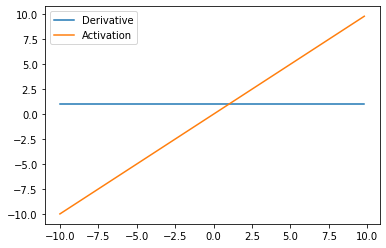

Your code PASSED the code check!


In [ ]:
def TEST_Linear():
    x = np.arange(-10, 10 , .2)
    y = Linear.activation(x)
    dy = Linear.derivative(x)

    plt.plot(x ,dy, label='Derivative')
    plt.plot(x ,y, label='Activation')
    plt.legend()
    plt.show()

    todo_check([
        (np.all(np.isclose(y[50:53], np.array([0. ,  0.2,  0.4]))), "y values are incorrect"),
        (np.all(np.isclose(dy[50:53], np.array([1., 1., 1.]))), "yd derivative values are incorrect")
    ])
    
TEST_Linear()
garbage_collect(['TEST_Linear'])

### Sigmoid

Next, we'll need to implement the  non-linear sigmoid activation function which squashes values between 0 and 1. Recall, the sigmoid activation function equation is given as follows:

$$
\begin{align}
g(z) &= \frac{1}{1 + e^{-z}} \\
&= \frac{e^z}{1 + e^{z}}
\end{align}
$$

Further the derivative of the sigmoid activation is given as follows:

$$
\begin{align}
g'(z) &= \frac{1}{1 + e^{-z}} (1 - \frac{1}{1 + e^{-z}}) \\
&= g(z)(1- g(z))
\end{align}
$$

#### TODO 7
Complete the TODO by implementing the `activation()` and `derivative()` static methods for the `Sigmoid` class.

1. Implement the `activation()` method by implementing the below version of the sigmoid function. Return the output of the equation.

$$
g(z) = \frac{e^z}{1 + e^{z}}
$$ 

2. Implement the `derivative()` method implementing the derivative of the sigmoid equation given above. Return the output of the equation.


In [ ]:
class Sigmoid():
    @staticmethod
    def activation(z):
        # TODO 7.1
        pass # Replace this line with your code
    
    @staticmethod
    def derivative(z):
        # TODO 7.2
        pass # Replace this line with your code

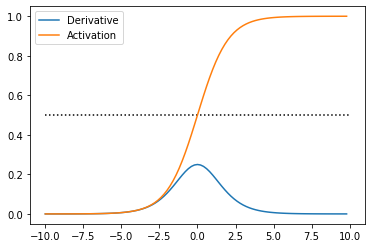

Your code PASSED the code check!


In [ ]:
def TEST_Sigmoid():
    x = np.arange(-10, 10 , .2)
    y = Sigmoid.activation(x)
    dy = Sigmoid.derivative(x)


    plt.hlines(.5, xmin=-10, xmax=10, colors='black', linestyles='dotted')
    plt.plot(x ,dy, label='Derivative')
    plt.plot(x ,y, label='Activation')
    plt.legend()
    plt.show()


    todo_check([
        (np.all(np.isclose(y[50:53], np.array([0.5, 0.549834  , 0.59868766]))), "y values are incorrect"),
        (np.all(np.isclose(dy[50:53], np.array([0.25, 0.24751657, 0.24026075]))), "yd derivative values are incorrect")
    ])


TEST_Sigmoid()
garbage_collect(['TEST_Sigmoid'])

### Tanh

Next, we'll need to implement the  non-linear $\tanh$  activation function which squashes values between -1 and 1. Recall, the $\tanh$  activation function equation is given as follows:

$$
\begin{align}
g(z) &= \tanh(z) \\
&= \frac{e^z - e^{-z}}{e^z + e^{-z}}
\end{align}
$$

Further, the derivative of the $\tanh$  activation is given as follows:

$$
\begin{align}
g'(z) &=  1 - \tanh^2(z)
\end{align}
$$

#### TODO 8

Complete the TODO by implementing the `activation()` and `derivative()` static methods for the `Tanh` class.

1. Implement the `activation()` method by implementing the $\tanh$  equation given above. Return the output of the equation.
    1. Hint: NumPy has already implemented a function for $\tanh$


2. Implement the `derivative()` method implementing the derivative of the $\tanh$ equation given above. Return the output of the equation.


In [ ]:
class Tanh():
    @staticmethod
    def activation(z):
        # TODO 8.1
        pass # Replace this line with your code
    
    @staticmethod
    def derivative(z):
        # TODO 8.2
        pass # Replace this line with your code

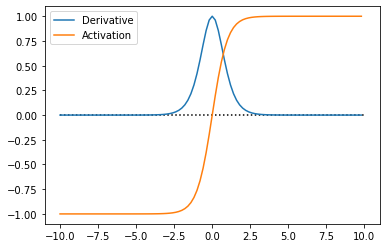

Your code PASSED the code check!


In [ ]:
def TEST_Tanh():
    x = np.arange(-10, 10 , .2)
    y = Tanh.activation(x)
    dy = Tanh.derivative(x)

    plt.hlines(0, xmin=-10, xmax=10, colors='black', linestyles='dotted')
    plt.plot(x ,dy, label='Derivative')
    plt.plot(x ,y, label='Activation')
    plt.legend()
    plt.show();


    todo_check([
        (np.all(np.isclose(y[50:53], np.array([0.,  0.19737532,  0.37994896]))), "y values are incorrect"),
        (np.all(np.isclose(dy[50:53], np.array([1., 0.96104298, 0.85563879]))), "yd derivative values are incorrect")
    ])
    
TEST_Tanh()
garbage_collect(['TEST_Tanh'])

## Forward pass

Now it's time to implement the feed-forward processes for our neural network algorithm. To do so we are going to look at how data flows through an 2 layer neural network. We'll use the below image of a 2 layer neural network as a schematic for our initial implementation. However, as we'll see, adding additional neurons will be trivial thanks to vector notation.

**This section will be notation heavy. If you get lost please refer to the notes or the table of notation located at the top of this notebook.**

Below is image of the base single layer neural network we will use to practice implementation. Note that it corresponds to our Forest Fire dataset as it has 29 feature inputs!

<img src="https://live.staticflickr.com/65535/51990549288_5a1aa0b89e_k.jpg" width="500" height="409" alt="single_layer_nn">



### Hidden layer

Alright, the first step in computing the predictions for a neural network is compute the output of the first layer. In our case, this is the first and only hidden layer. Below is the image of the hidden layer and the input layer. The input layer will provide the inputs that the hidden layer will use to compute its outputs. 

The hidden layer will have 2 hidden units or neurons where each hidden neuron will use the sigmoid activation function.

<img src="https://live.staticflickr.com/65535/51990489126_be1cd013c6_h.jpg" width="300" height="209" alt="signle_nn_hidden_layers">

*Note, the red arrow in the picture points in the direction information is flowing. In this case, information is flowing forwards.*

#### TODO 9

Complete the TODO by implementing each equation to compute the output of the hidden layer using the training data `X_trn` and `y_trn`.

**Initialization**
1. Initialize the weights $\Wm^{[1]}$ for the hidden layer. Store the output into `W1`. To do so, use the following tips:
    1. The inputs for the hidden layer correspond to the **number of features** in the passed input data, in this case `X_trn`. 
    1. The hidden layer should have 2 hidden units or neurons.

    1. The weights should have the shape (neurons, inputs). Think about what the inputs are and how many neurons the hidden layer has.
    1. Use the NumPy's `rng.uniform()` function ([docs](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html)) to randomly generate the weight matrix of shape (neurons, inputs). The weight values should be restricted between the range of -0.5 (minimum) and 0.5 (maximum). 
2. Initialize the biases $\bv^{[1]}$ for the hidden layer. Store the output into `b1`. To do so, use the following tips:
    1. The biases should be a vector of all 1s with the shape (neurons, 1). Try using `np.ones()` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.ones.html)).

**Computing linear combinations**

3. Compute $\Zm^{[1]}$ the linear combination of the input features with the weights for ALL neurons in the hidden layer simultaneously using `X_trn` as the input. Convert the below equation to do so where you might need to transpose certain variables. Store the output into `Z1`.
    1. Hint: The input data `X_trn` must be of shape (features, data samples). However, to work with our neural network algorithm, we need `X_trn` to have the shape (data samples, features).
$$
\Zm^{[1]} = \Wm^{[1]} \Xm+ \bv^{[1]}.
$$

**Computing layer outputs**

4. Compute $\Am^{[1]} $ the output of ALL neurons in the hidden layer simultaneously by applying the sigmoid activation function to the linear combination output $\Zm^{[1]}$. Convert the below equation where $g$ is the `Sigmoid` class and the `activation()` static method applies the activation function equation. Store the output into `A1`.
    1. Hint: To call a static method such as the `activation()` method for the `Sigmoid` class you DO NOT need to instantiate the class. See an example in this [post](https://stackoverflow.com/questions/11759269/calling-static-method-in-python).

$$
\Am^{[1]} = g(\Zm^{[1]})
$$

In [ ]:
data = data_prep(df=forestfire_df, label_name='area', return_array=True)
X_trn, y_trn, _, _, _,_ = data

print(f"X_trn shape: {X_trn.shape}")

X_trn shape: (327, 29)


In [ ]:
rng = np.random.RandomState(0)

# TODO 9.1
W1 = 

# TODO 9.2
b1 =

print(f"Hidden layer weights shape: {W1.shape}")
print(f"Hidden layer bias shape: {b1.shape}")

todo_check([
    (W1.shape == (2, 29), "W1 has the wrong shape"),
    (b1.shape == (2, 1), "b1 has the wrong shape"),
    (np.all(np.isclose(W1[0][:3], np.array([0.0488135 , 0.21518937, 0.10276338]), rtol=.01)), "W1 has incorrect values"),
    (np.all(b1 == 1), 'b1 has incorrect values')
])

Hidden layer weights shape: (2, 29)
Hidden layer bias shape: (2, 1)
Your code PASSED the code check!


In [ ]:
# TODO 9.3
Z1 =

print(f"{Z1.shape} =  {W1.shape} @ {X_trn.T.shape} + {b1.shape}")
print(f"Z1 shape: {Z1.shape}")

todo_check([
    (Z1.shape == (2, 327), "Z1 has the wrong shape"),
    (np.all(np.isclose(Z1[0][:3], np.array([1.10623323, 0.96034753, 0.46206967]), rtol=.01)), "Z1 has incorrect values")
])

(2, 327) =  (2, 29) @ (29, 327) + (2, 1)
Z1 shape: (2, 327)
Your code PASSED the code check!


In [ ]:
# TODO 9.4
A1 =

print(f"A1 shape: {A1.shape}")

todo_check([
    (A1.shape == (2, 327), "A1 has the wrong shape"),
    (np.all(np.isclose(A1[0][:3], np.array([0.7514262 , 0.72319138, 0.61350504]), rtol=.01)), "A1 has incorrect values")
])

A1 shape: (2, 327)
Your code PASSED the code check!


### Output Layer

The final step in computing the predictions for a neural network is to compute the output of the 2nd layer (i.e., output layer). Below is the image of the hidden layer and the output layer. The hidden layer will provide the inputs that the output layer will use to compute its SINGLE output for each data sample.

The output layer will have 1 hidden unit or neuron which utilizes the identity/linear activation function (i.e., no activation function).

<img src="https://live.staticflickr.com/65535/51990775824_3574bc97a4_h.jpg" width="300" height="239" alt="signle_nn_output_layer">

*Note, the red arrow in the picture points in the direction information is flowing. In this case, information is flowing forwards.*

#### TODO 10

Complete the TODO by implementing each equation to compute the output of the output layer using the output from the hidden layer `A1`.

**Initialization**
1. Initialize the weights $\wv^{[2]}$ of the output layer. Store the output into `W2`. To do so, use the following tips:
    1. The inputs for the output layer correspond to the number of outputs from the previous layer's neurons `A1`. 
    1. The output layer should have 1 neuron.
    1. The weights should have the shape (neurons, inputs). Think about how many neurons were in the previous layer and how many neurons the output layer has.
    1. Use the NumPy's `rng.uniform()` function ([docs](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html)) to randomly generate the weight matrix of shape (neurons, inputs). The weight values should be restricted between the range of -0.5 (minimum) and 0.5 (maximum). 
2. Initialize the biases $\bv^{[2]}$ of the output layer. Store the output into `b2`. To do so, use the following tips:
    1. The biases should be a vector of all 1s with the shape (neurons, 1). Try using `np.ones()` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.ones.html)).

**Computing linear combinations**

3. Compute $\zv^{[2]} $ the linear combination of the input features with the weights for ALL neurons in the output layer simultaneously. Convert the below equation to do so. Store the output into `Z2`.

$$
\zv^{[2]} = \wv^{[2]} \Am^{[1]} + \bv^{[2]}.
$$

**Computing layer outputs**

4. Compute $\av^{[2]}$ the output of ALL neurons in the output layer simultaneously by applying the identity/linear activation function (i.e., no activation function) to the linear combination output $\zv^{[1]}$. Convert the below equation to do so where $g$ is the `Linear` class and the `activation()` static method applies the activation function equation. Store the output into `A2`.
    1. Hint: To call a static method such as the `activation()` method for the `Linear` class you DO NOT need to instantiate the class. See an example in this [post](https://stackoverflow.com/questions/11759269/calling-static-method-in-python).

$$
\av^{[2]} = g(\zv^{[2]})
$$

In [ ]:
rng = np.random.RandomState(1)

# TODO 10.1
W2 = 
# TODO 10.2
b2 =

print(f"Input activations A1 shape: {A1.shape}")
print(f"Output layer weights shape: {W2.shape}")
print(f"Output layer bias shape: {b2.shape}")

todo_check([
    (W2.shape == (1, 2), "W2 has the wrong shape"),
    (b2.shape == (1, 1), "b1 has the wrong shape"),
    (np.all(np.isclose(W2[0][:3], np.array([-0.082978  ,  0.22032449]), rtol=.01)), "W2 has incorrect values"),
    (np.all(b2 == 1), "b1 has incorrect values"),
])

Input activations A1 shape: (2, 327)
Output layer weights shape: (1, 2)
Output layer bias shape: (1, 1)
Your code PASSED the code check!


In [ ]:
# TODO 10.3
Z2 =

print(f"{Z2.shape} =  {W2.shape} @ {A1.shape} + {b2.shape}")
print(f"Z2 shape: {Z2.shape}")

todo_check([
    (Z2.shape == (1, 327), "Z2 has the wrong shape"),
    (np.all(np.isclose(Z2[0][:3], np.array([1.10726381, 1.06542374, 1.13297247]), rtol=.01)), "Z2 has incorrect values"),
])

(1, 327) =  (1, 2) @ (2, 327) + (1, 1)
Z2 shape: (1, 327)
Your code PASSED the code check!


In [ ]:
# TODO 10.4
A2 =

print(f"A2 shape: {A2.shape}")

todo_check([
    (A2.shape == (1, 327), "A2 has the wrong shape"),
    (np.all(np.isclose(A2[0][:3], np.array([1.10726381, 1.06542374, 1.13297247]), rtol=.01)), "A2 has incorrect values"),
])

A2 shape: (1, 327)
Your code PASSED the code check!


Notice we need to transpose `A2` the output from the output layer to make the predictions match the shape of the original labels `y_trn` (data samples, 1). We have to do this because we transposed the inputs to be (data samples, features).

In [ ]:
A2.shape

(1, 327)

In [ ]:
y_trn.shape

(327, 1)

In [ ]:
y_hat = A2.T
y_hat.shape

(327, 1)

In [ ]:
garbage_collect(['data', 'X_trn', 'y_trn', 'y_hat', 'A2', 'Z2', 'b2', 'W2', 'rng', 'A1', 'Z1', 'b1', 'W1', 'n_input_features', 'hidden_neurons'])

### Putting it all together

We can put all the code together by putting the weight and bias initializations into a function called `init_weights()` and the forward pass code into a function called `forward()`.

The `init_weights()` function will simply initialize the weights and biases for each layer for us and return them in a `weights` dictionary and a `bias` dictionary. The `forward()` function will apply the forward pass for all layers starting from the input layer and ending with the output layer.

#### TODO 11
Complete the TODO by moving the code you used for prior TODOs into the `init_weights()` function.

1. Initialize the weights using the instructions given in `TODO 10.1`. Use the `n_inputs_features`, `hidden_neurons`, and `output_neurons` arguments to determine the weight shapes for the hidden and output layers. Store the hidden layer weights into the dictionary `W` with the key `W1`.  Store the output layer weights into the dictionary `W` with the key `W2`.


2. Initialize the biases  using the instructions given in `TODO 10.2`. Use the  `hidden_neurons` and `output_neurons` arguments to determine bias shapes for the hidden and output layers. Store the hidden layer biases into the dictionary `b` with the key `b1`.  Store the output layer biases into the dictionary `b` with the key `b2`.

In [ ]:
def init_weights(
    n_input_features: int, 
    hidden_neurons: int, 
    output_neurons: int, 
    seed=0) -> Tuple[dict, dict]:
    """ Initilize a two layer neural network's weights and baises
        
        Args:
            n_input_features: The number of input features

            hidden_neurons: The number of hidden neurons or units to 
                use in the hidden layer.

            output_neurons: The number of output neurons to use in 
                the output layer.
    """
    
    W = {}
    b = {}
    
    rng = np.random.RandomState(seed)
    # TODO 11.1
    W['W1'] = 
    W['W2'] =
    # TODO 11.2
    b['b1'] =
    b['b2'] =
    
    return W, b

Run the below `TEST_init_weights()` function to test your implementation of the `init_weights()` function.

In [ ]:
def TEST_init_weights():
    # Get training data
    data = data_prep(df=forestfire_df,label_name='area', return_array=True)
    X_trn, y_trn, _, _, _,_ = data

    # Init weights and baises
    W, b = init_weights(
        n_input_features=X_trn.shape[1],
        hidden_neurons=2,
        output_neurons=1
    )
    
    display(W)
    display(b)

    todo_check([
        ('W1' in W, "W dict is missing key 'W1'"),
        ('W2' in W, "W dict is missing key 'W2'"),
        ('b1' in b, "b dict is missing key 'b1'"),
        ('b2' in b, "b dict is missing key 'b2'"),
        (W['W1'].shape == (2, X_trn.shape[1]), "W['W1'] has the wrong shape"),
        (W['W2'].shape == (1, 2), "W['W2'] has the wrong shape"),
        (b['b1'].shape == (2, 1), "b['b1'] has the wrong shape"),
        (b['b2'].shape == (1, 1), "b['b2'] has the wrong shape"),
        (np.all(np.isclose(W['W1'][0][:3], np.array([0.0488135 , 0.21518937, 0.10276338]), rtol=.01)), "W['W1'] has incorrect values"),
        (np.all(b['b1']  == 1), "b['b1'] has incorrect values"),
        (np.all(np.isclose(W['W2'][0][:3], np.array([-0.03368923, -0.25557441]), rtol=.01)), "W['W2'] has incorrect values"),
        (np.all(b['b2'] == 1), "b['b2'] has incorrect values"),
    ])
    
TEST_init_weights()
garbage_collect(['TEST_init_weights'])

{'W1': array([[ 0.0488135 ,  0.21518937,  0.10276338,  0.04488318, -0.0763452 ,
          0.14589411, -0.06241279,  0.391773  ,  0.46366276, -0.11655848,
          0.29172504,  0.02889492,  0.06804456,  0.42559664, -0.42896394,
         -0.4128707 , -0.4797816 ,  0.33261985,  0.27815675,  0.37001215,
          0.47861834,  0.29915856, -0.03852064,  0.28052918, -0.38172557,
          0.13992102, -0.35664671,  0.44466892,  0.02184832],
        [-0.08533806, -0.23544439,  0.27423369, -0.04384967,  0.06843395,
         -0.4812102 ,  0.1176355 ,  0.11209572,  0.116934  ,  0.44374808,
          0.1818203 , -0.1404921 , -0.06296805,  0.1976312 , -0.43977453,
          0.16676672,  0.17063787, -0.28961744, -0.3710737 , -0.18457165,
         -0.13628923,  0.07019677, -0.06139849,  0.48837384, -0.39795519,
         -0.29112324, -0.33869048,  0.15310833, -0.2467084 ]]),
 'W2': array([[-0.03368923, -0.25557441]])}

{'b1': array([[1.],
        [1.]]),
 'b2': array([[1.]])}

Your code PASSED the code check!


#### TODO 12
Complete the TODO by recoding the code you used for prior TODOs inside the `forward()` function. Notice, the weights and biases are stored in dictionaries now. Further, the activation function for ALL the hidden layer neurons is passed to the `g_hidden` argument while the activation function for ALL the output layer neurons is passed to the `g_output` argument. You'll need to update the code to match these changes.

**Input layer**

1. Store the transposed input features `X` into the dictionary `As` with the key `A0`. Recall, neural networks only take input features with the shape (features, data samples). Further, the notation $\Am^{[0]}$ is often used to represent $\Xm$ as the output for the input layer.

**Hidden layer**

Inputs are stored in `As['A0']`, weights are stored in `W['W1']` and biases are stored in `b['b1']` and activation function for the neurons is stored in `g_hidden` argument.

2. Compute $\Zm^{[1]}$ the linear computation of inputs for ALL neurons using `As['A0']`. Store the output into the dictionary `Zs` with the key `Z1`.
$$
\Zm^{[1]} = \Wm^{[1]} \Am^{[0]}+ \bv^{[1]}.
$$
3. Compute $\Am^{[1]}$ the activation output for ALL neurons. Store the output into the dictionary `As` with the key `A1`.
$$
\Am^{[1]} = g(\Zm^{[1]})
$$

**Output layer**

Inputs are stored in `As['A1']`, weights are stored in `W['W2']`, biases are stored in `b['b2']` and activation function for the neuron is stored in `g_output` argument.

4. Compute $\zv^{[2]}$ the linear computation of inputs for ALL neurons. Store the output into the dictionary `Zs` with the key `Z2`.
$$
\zv^{[2]} = \wv^{[2]} \Am^{[1]} + \bv^{[2]}.
$$
5. Compute $\av^{[2]}$ the activation output for ALL neurons. Store the output into the dictionary `As` with the key `A2`.
$$
\av^{[2]} = g(\zv^{[2]})
$$
6. Transpose the output layer output `As['A2']` to make predictions match the shape of the ground truth which is (data samples, 1). Store the output into `y_hat`.

$$
\hat{\yv} = \av^{[2]\top}
$$


In [ ]:
def forward(
    X: np.ndarray, 
    W: Dict[str, np.ndarray], 
    b:  Dict[str, np.ndarray], 
    g_hidden: object, 
    g_output: object) -> Tuple[np.ndarray, dict, dict]:
    """ Forward pass for 2 layer neural network
    
        Args:
            X: Input features
            
            W: Weights for all layers given as a dictionary
            
            b: Biases for all layers given as a dictionary
            
            g_hidden: Activation class containing a static method 
                called activation() for the first hidden layer.
                
            g_output: Activation class containing a static method 
                called activation() for the output layer.
    """
    
    Zs = {}
    As = {}
    # Input layer
    # TODO 12.1
    As['A0'] =
    
    # hidden layer
    # TODO 12.2
    Zs['Z1'] =
    # TODO 12.3
    As['A1'] = 
    
    # Output layer
    # TODO 12.4
    Zs['Z2'] =
    # TODO 12.5
    As['A2'] =
    # TODO 12.6
    y_hat =
    
    return y_hat, Zs, As

Run the below code to test your implementation of the `forward()` function.

In [ ]:
# Get training data
data = data_prep(df=forestfire_df, label_name='area', return_array=True)
X_trn, y_trn, _, _, _,_ = data

# Init weights and baises
W, b = init_weights(
    n_input_features=X_trn.shape[1],
    hidden_neurons=2,
    output_neurons=1
)

# Perform 1 forward pass
y_hat, Zs, As = forward(
    X=X_trn, 
    W=W,
    b=b, 
    g_hidden=Sigmoid, 
    g_output=Linear
)

# Compute performance measures
sse_score = sse(y=y_trn, y_hat=y_hat)
mse_score = mse(y=y_trn, y_hat=y_hat)

todo_check([
    (y_hat.shape == (327, 1), "y_hat has the wrong shape"),
    (As['A0'].shape == (29, 327), "As['A0'] has the wrong shape"),
    (Zs['Z1'].shape == (2, 327), "Zs['Z1'] has the wrong shape"),
    (Zs['Z2'].shape == (1, 327), "Zs['Z2'] has the wrong shape"),
    (np.isclose(sse_score, 680.360, rtol=.01), 'sse_score is incorrect'),
    (np.isclose(mse_score, 2.080612, rtol=.01),'mse_score is incorrect'),
    (np.all(np.isclose(As['A1'][0][:3], np.array([0.7514262 , 0.72319138, 0.61350504]),rtol=.01)), "As['A1'] has incorrect values"),
    (np.all(np.isclose(As['A2'][0][:3], np.array([0.77793242, 0.83013544, 0.76603249]),rtol=.01)), "As['A2'] has incorrect values"),
])

Your code PASSED the code check!


Below, you can see the output for the the `sse_score`, `mse_score`, `y_hat`, `W`, `b`, `Zs`, and `As`. Keep in mind, `W`, `b`, `Zs`, and `As` are all dictionaries where the keys correspond to layers!!

In [ ]:
sse_score

680.360422268039

In [ ]:
mse_score

2.0806129121346757

In [ ]:
W

{'W1': array([[ 0.0488135 ,  0.21518937,  0.10276338,  0.04488318, -0.0763452 ,
          0.14589411, -0.06241279,  0.391773  ,  0.46366276, -0.11655848,
          0.29172504,  0.02889492,  0.06804456,  0.42559664, -0.42896394,
         -0.4128707 , -0.4797816 ,  0.33261985,  0.27815675,  0.37001215,
          0.47861834,  0.29915856, -0.03852064,  0.28052918, -0.38172557,
          0.13992102, -0.35664671,  0.44466892,  0.02184832],
        [-0.08533806, -0.23544439,  0.27423369, -0.04384967,  0.06843395,
         -0.4812102 ,  0.1176355 ,  0.11209572,  0.116934  ,  0.44374808,
          0.1818203 , -0.1404921 , -0.06296805,  0.1976312 , -0.43977453,
          0.16676672,  0.17063787, -0.28961744, -0.3710737 , -0.18457165,
         -0.13628923,  0.07019677, -0.06139849,  0.48837384, -0.39795519,
         -0.29112324, -0.33869048,  0.15310833, -0.2467084 ]]),
 'W2': array([[-0.03368923, -0.25557441]])}

In [ ]:
b

{'b1': array([[1.],
        [1.]]),
 'b2': array([[1.]])}

In [ ]:
Zs

{'Z1': array([[ 1.10623323,  0.96034753,  0.46206967, -0.50514863,  0.12042766,
          1.77345091,  2.35575052, -8.57522445,  0.85582786, -0.19400628,
          1.91059301,  1.93048677, -0.14456068,  3.34177131, -0.50316614,
          1.33407706,  0.07615618, -1.16500805,  2.53290132, -1.15991197,
          0.69577067,  3.18048908,  0.17076103, -5.64857572, -0.3027869 ,
          0.73075035,  3.51702609, -1.5448738 ,  3.09180038,  0.89992932,
         -0.10758145,  1.122188  , -5.71263948,  2.20147576,  1.1606645 ,
         -0.56128324,  1.64751464,  0.77999293,  1.42898251, -1.02015898,
         -1.17329561,  1.46670255,  1.44556629,  2.79207385,  1.15427591,
         -0.51640409,  0.15800634,  2.66730807,  0.57480769,  0.29678078,
          2.00942184,  1.93174222,  3.3773085 ,  1.13748623,  0.73517526,
          1.60971249,  1.21141017, -1.99001044,  1.17441071,  0.84931772,
          1.11596178,  1.00474429,  2.64382002,  3.44783131, -0.9193632 ,
         -0.59130026,  1.1053343

Notice that the key `A0` corresponds to then input features transposed (features, data samples) and `A2` corresponds to the predictions transposed (1, data samples). Recall, `A1` is just the output of the hidden layer.

In [ ]:
As

{'A0': array([[-0.43980752, -0.43980752, -0.43980752, ..., -0.43980752,
         -0.43980752,  2.27372191],
        [-0.39946773, -0.39946773, -0.39946773, ...,  2.50333111,
         -0.39946773, -0.39946773],
        [-0.43980752, -0.43980752, -0.43980752, ..., -0.43980752,
          2.27372191, -0.43980752],
        ...,
        [-0.001283  ,  2.21628288,  0.29838807, ..., -0.60062512,
         -1.19996725,  1.01759862],
        [-0.25325416,  1.27823968, -1.04736209, ..., -1.27425006,
          0.48413176,  0.76774173],
        [-0.08564231, -0.08564231, -0.08564231, ..., -0.08564231,
         -0.08564231, -0.08564231]]),
 'A1': array([[0.7514262 , 0.72319138, 0.61350504, 0.37633149, 0.53007058,
         0.8548863 , 0.91339023, 0.00018869, 0.70178824, 0.45164999,
         0.87108575, 0.87330329, 0.46392264, 0.96583434, 0.3767969 ,
         0.79151423, 0.51902985, 0.23775849, 0.92641638, 0.23868328,
         0.66724941, 0.96009341, 0.54258683, 0.00351017, 0.42487634,
         0.67496

## Backward pass
Now it's time to update the weights and biases using backpropagation. In order to do so remember we first need to perform the forward pass to get the predictions. We then need to assess the error/loss using our loss function, MSE in this case. 

Given the loss we can backpropagate the error through the network to update the weights in the direction that minimizes the loss (i.e., makes the total average loss smaller). Remember backpropagate here just means finding the gradient with respect to each of the parameters $\Wm^{[1]}$, $\bv^{[1]}$, $\Wm^{[2]}$, and $\bv^{[2]}$.

Recall, we can write out all the equations for our 2 layer neural network including the loss as follows:


1. Hidden layer (layer 1) equations

$$
\Zm^{[1]} = \Wm^{[1]} \Xm + \bv^{[1]}
$$

$$
\Am^{[1]} = g(\Zm^{[1]} )
$$

2. Output layer (layer 2) equations

$$
\zv^{[2]} = \wv^{[2]} \Am^{[1]} + \bv^{[2]}
$$

$$
\av^{[2]} = g(\zv^{[2]})
$$

3. MSE loss
$$
 \hat{\yv} = \av^{[2]\top} 
$$

$$
MSE = \frac{1}{2m} (\hat{\yv} - {\yv})^2 
$$

The goal will be to solve for $\frac{\partial MSE}{\partial  \Wm^{[1]}}$, $\frac{\partial MSE}{\partial \bv^{[1]}}$,  $\frac{\partial MSE}{\partial \wv^{[2]}}$, and $\frac{\partial MSE}{\partial \bv^{[2]}}$ where the MSE loss will be the "parent" or root equation where the computation of computing each gradient starts. Given the partial derivatives, we can then perform the following gradient descent updates.

**Hidden layer updates**
$$
\Wm^{[1]} = \Wm^{[1]} - \alpha \nabla \frac{\partial MSE}{\partial  \Wm^{[1]}}
$$

$$
\bv^{[1]} = \bv^{[1]} - \alpha \nabla \frac{\partial MSE}{\partial  \bv^{[1]}}
$$
**Output layer updates**
$$
\Wm^{[2]} = \wv^{[2]} - \alpha \nabla \frac{\partial MSE}{\partial  \wv^{[2]}}
$$

$$
\bv^{[2]} = \bv^{[2]} - \alpha \nabla \frac{\partial MSE}{\partial  \bv^{[2]}}
$$




### MSE Derivative 

Before we start, we need to compute the derivative of the MSE loss function as it will act as the "parent" or root equation where each partial derivative equation will start from. 

#### TODO 13
Complete the TODO by implementing the derivative of the MSE loss function inside the `delta_mse()` function.

1. Compute the derivative of the MSE loss function and return the output. The MSE derivative is given as follows:

$$
\frac{\partial MSE}{\partial \hat{\yv}} = \hat{\yv} - \yv
$$
where $ \hat{\yv} = \av^{[2]\top}$.

In [ ]:
def delta_mse(y, y_hat):
    # TODO 13.1
    pass # Replace this line with your code

Run the below code to test your implementation of the `delta_mse()` function.

In [ ]:
def TEST_delta_mse():
    fake_y = np.array([[.2, 1.2, 3.4]])
    fake_y_hat = np.array([[1.5, 1.1, 3.0]])
    fake_delta_mse = delta_mse(fake_y, fake_y_hat)

    todo_check([
        (np.all(np.isclose(fake_delta_mse, np.array([[ 1.3, -0.1, -0.4]]), rtol=.01)), "delta_mse has an incorrect value")
    ])
    
TEST_delta_mse()
garbage_collect(['TEST_delta_mse'])

Your code PASSED the code check!


### Output Layer

To start off, we first compute the derivative of the parent function, the MSE loss, and then slowly compute the derivatives of each equation up until we reach the desired weight and bias parameter. The first parameters we will run into are the weights and biases for the output layer. Thus, we'll compute the partial derivatives $\frac{\partial MSE}{\partial \wv^{[2]}}$ and $\frac{\partial MSE}{\partial \bv^{[2]}}$ first as they are the first parameters we run into when propagating backwards through the network.

This process is visually depicted with the below image where we are backpropagating through the network up to the end of the output layer.

<img src="https://live.staticflickr.com/65535/51990775829_30775493eb_h.jpg" width="300" height="246" alt="signle_nn_output_layers_back">

To compute the gradient or partial derivative of the weights $\Wm^{[2]}$ and bias $\bv^{[2]}$ we need the following equations:

$$
\begin{align}
MSE &= \frac{1}{2m} (\av^{[2]\top} - {\yv})^2  \\ 
 \\
\av^{[2]} &= g(\zv^{[2]}) \\
\\
\zv^{[2]} &= \wv^{[2]} \Am^{[1]} + \bv^{[2]}
\end{align}
$$

where $\hat{\yv} = \av^{[2]\top}$.

<hr>

**Weights**

If we expand $\frac{\partial MSE}{\partial \wv^{[2]}}$ we get the following equation that we need to solve:
$$
\frac{\partial MSE}{\partial \wv^{[2]}} = \frac{\partial MSE}{\partial \av^{[2]}}\frac{\partial \av^{[2]}}{\partial \zv^{[2]} }\frac{\partial \zv^{[2]} }{\partial  \wv^{[2]} }
$$

If we compute the derivative of each of the partial derivatives we get the following:

$$
\begin{align}
\frac{\partial MSE}{\partial \av^{[2]}} &= (\av^{[2]\top} - {\yv}) \\
\frac{\partial \av^{[2]}}{\partial \zv^{[2]} } &= \mathbf{1} \\
\frac{\partial \zv^{[2]} }{\partial  \wv^{[2]} } &= \Am^{[1]}
\end{align}
$$

Sadly, we can't always compute $\frac{\partial MSE}{\partial \wv^{[2]}}$ by simply multiplying all the values for the expanded partial derivative equation. Since we are working with vectors and matrices we need to utilize the dot product and, in turn, rearrange some of the partial derivatives. 

$$
\begin{align}
\frac{\partial MSE}{\partial \wv^{[2]}} &=  \frac{\partial MSE}{\partial \av^{[2]}} \frac{\partial \av^{[2]}}{\partial \zv^{[2]} } \frac{\partial \zv^{[2]}}{\partial  \wv^{[2]}}\\
\\
&=  \big (\frac{\partial MSE}{\partial \av^{[2]}}^\top * \frac{\partial \av^{[2]}}{\partial \zv^{[2]} } \big ) \cdot \frac{\partial \zv^{[2]}}{\partial  \wv^{[2]}}^\top  \\
\\
&= \big( (\av^{[2]} - {\yv})^\top * \mathbf{1} \big )  \cdot  \Am^{[1]\top}
\end{align}
$$
where $\cdot$ represents the dot product and $*$ represents element-wise multiplication. Notice, that the equation inherently computes the sum of the gradients due to the addition of the dot product. This means we only need to divide by the number of data samples used to compute the gradient to get the average gradient.

<!-- *Note: this general equation is needed as we could have the following shape issues when performing element-wise multiplication where we have 2 output neurons, 100 data samples, and 3 hidden units: $\big[(\av^{[2]}(2, 100) - \yv(2, 100))^\top * \mathbf{1}(2, 100) \big ] * \Am^{[1]}(3, 100)$. Notice, $(2, 100)$ can note be element-wise multiplied with a $(3, 100)$*
 -->
<hr>

**Bias**

If we expand $\frac{\partial MSE}{\partial \bv^{[2]}}$ we get the following equation that we need to solve:
$$
\frac{\partial MSE}{\partial \bv^{[2]}} = \frac{\partial MSE}{\partial \av^{[2]}}\frac{\partial \av^{[2]}}{\partial \zv^{[2]} }\frac{\partial \zv^{[2]} }{\partial  \bv^{[2]} }
$$
Notice, the only NEW partial derivative is $\frac{\partial \zv^{[2]} }{\partial \bv^{[2]}}$, the rest we have already seen before. If we compute the partial derivatives we get the following:

$$
\begin{align}
\frac{\partial \zv^{[2]} }{\partial  \bv^{[2]} } &= \mathbf{1}
\end{align}
$$

Using the same equation format as the output layer weight update, we can compute $\frac{\partial MSE}{\partial \bv^{[2]}}$ by using the dot product and element-wise multiplication.


$$
\begin{align}
\frac{\partial MSE}{\partial \bv^{[2]}} &=  (\frac{\partial MSE}{\partial \av^{[2]}} * \frac{\partial \av^{[2]}}{\partial \zv^{[2]} }) \cdot \frac{\partial \zv^{[2]}}{\partial  \bv^{[2]}}^\top \\
&=  \big ( (\av^{[2]} - {\yv})^\top * \mathbf{1} \big ) \cdot \mathbf{1}^\top
\end{align}
$$

 Notice, that the equation inherently computes the sum of the gradients due to the addition of the dot product. This means we only need to divide by the number of data samples used to compute the gradient to get the average gradient.

<!-- *Note: We could use a similar general equation (as we'll see for the hidden layer bias) that utilizes the dot product for computing $\frac{\partial MSE}{\partial \bv^{[2]}}$. However, it is never needed to prevent shape mismatch errors as the derivative of $\frac{\partial \zv^{[2]} }{\partial  \bv^{[2]} }$ is always 1.* -->

In [ ]:
print(f"W['W2'] shape: {W['W2'].shape}")
W['W2']

W['W2'] shape: (1, 2)


array([[-0.03368923, -0.25557441]])

In [ ]:
print(f"b['b2'] shape: {b['b2'].shape}")
b['b2']

b['b2'] shape: (1, 1)


array([[1.]])

#### TODO 14
Complete the TODO by finishing the `get_output_layer_grads()` function to compute the gradients for the output layer weights and biases. **Use the partial derivative solutions and convert them into code where each of the partial derivatives map to the following variables:**
- $\frac{\partial MSE}{\partial \av^{[2]}}$ corresponds to  `delta_mse_A2` 
- $\frac{\partial \av^{[2]}}{\partial \zv^{[2]} }$ corresponds to `delta_A2_Z2`
- $ \frac{\partial \zv^{[2]}}{\partial \wv^{[2]} }$ corresponds to `delta_Z2_W2`
- $\frac{\partial \zv^{[2]} }{\partial \bv^{[2]} }$ corresponds to `delta_Z2_B2` 

*Note: delta corresponds to $\partial$.*

**Output layer weight gradients**
$$
\begin{align}
\frac{\partial MSE}{\partial \wv^{[2]}} &=  \big (\frac{\partial MSE}{\partial \av^{[2]}}^\top * \frac{\partial \av^{[2]}}{\partial \zv^{[2]} } \big ) \cdot \frac{\partial \zv^{[2]}}{\partial  \wv^{[2]}}^\top  \\
\\
&= \big( (\av^{[2]} - {\yv})^\top * \mathbf{1} \big )  \cdot  \Am^{[1]\top}
\end{align}
$$

1. Compute the partial derivative solution $\frac{\partial MSE}{\partial \wv^{[2]}}$ for the output layer weights $\Wm^{[2]}$. Store the output into `delta_mse_W2`.

2. Compute the average gradient for $\frac{\partial MSE}{\partial \wv^{[2]}}$ by dividing the number of data samples. Store the output into `W2_avg_grad`.

**Output layer bias gradients**
$$
\begin{align}
\frac{\partial MSE}{\partial \bv^{[2]}} &=  (\frac{\partial MSE}{\partial \av^{[2]}} * \frac{\partial \av^{[2]}}{\partial \zv^{[2]} }) \cdot \frac{\partial \zv^{[2]}}{\partial  \bv^{[2]}}^\top \\
&=  \big ( (\av^{[2]} - {\yv})^\top * \mathbf{1} \big ) \cdot \mathbf{1}^\top
\end{align}
$$

3. Compute the partial derivative solution $\frac{\partial MSE}{\partial \bv^{[2]}}$ for the output layer weights $\bv^{[2]}$. Store the output into `delta_mse_b2`.

4. Compute the average gradient for $\frac{\partial MSE}{\partial \bv^{[2]}}$ by dividing by the number of data samples. Store the output into `b2_avg_grad`.

In [ ]:
def get_output_layer_grads(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    Zs: dict, 
    As: dict, 
    g_output: object, 
    verbose: bool = False
):
    """ Compute gradients for output layer parameters
    
        Args:
            y: NumPy array of labels
            
            y_hat: NumPy array of predictions
            
            Zs: Dictionary containing values for the linar combination
                of each layer with the weights and inputs
            
            g_output: Activation function class for output layer
            
            verbose: If true, all extra information print statements
                will be printed.
    
    """
    delta_mse_A2 = delta_mse(y, y_hat)
    delta_A2_Z2 = g_output.derivative(Zs['Z2'])
    delta_Z2_W2 = As['A1']
    delta_Z2_b2 = np.ones([1, len(y)])
    
    if verbose:
        print(f"\ny shape: {y.shape}")
        print(f"y_hat shape: {y_hat.shape}")
        print(f"delta_mse_A2 shape: {delta_mse_A2.shape}")
        print(f"delta_A2_Z2 shape: {delta_A2_Z2.shape}")
        print(f"delta_Z2_W2 shape: {delta_Z2_W2.shape}")
        print(f"delta_Z2_b2 shape: {delta_Z2_b2.shape}\n")
    
    # TODO 14.1
    delta_mse_W2 = 
    # TODO 14.2
    W2_avg_grad =
    
    # TODO 14.3
    delta_mse_b2 =
    # TODO 14.4
    b2_avg_grad =
    
    return W2_avg_grad, b2_avg_grad

Run the below code to test your implementation of the `get_output_layer_grads()` function.

In [ ]:
W2_avg_grad, b2_avg_grad = get_output_layer_grads(
    y=y_trn, 
    y_hat=y_hat, 
    Zs=Zs, 
    As=As, 
    g_output=Linear, 
    verbose=True
)

print(f"Output layer weight grads:{W2_avg_grad}")
print(f"Output layer bias grads:{b2_avg_grad}\n")

todo_check([
    (W2_avg_grad.shape == (1, 2), "W2_avg_grad has the wrong shape"),
    (b2_avg_grad.shape == (1, 1), "b2_avg_grad has the wrong shape"),
    (np.all(np.isclose(W2_avg_grad, np.array([[-0.27083818, -0.26163788]]),rtol=.01)), "W2_avg_grad has incorrect values"),
    (np.all(np.isclose(b2_avg_grad, np.array([[-0.3407989]]),rtol=.01)), "b1_avg_grad has incorrect values"),
])


y shape: (327, 1)
y_hat shape: (327, 1)
delta_mse_A2 shape: (327, 1)
delta_A2_Z2 shape: (1, 327)
delta_Z2_W2 shape: (2, 327)
delta_Z2_b2 shape: (1, 327)

Output layer weight grads:[[-0.27083818 -0.26163788]]
Output layer bias grads:[[-0.3407989]]

Your code PASSED the code check!


#### TODO 15 
Complete the TODO by updating the weights and biases for the output layer. Use the following update equations for the weights and biases:
$$
\Wm^{[2]} = \wv^{[2]} - \alpha \nabla \frac{\partial MSE}{\partial  \wv^{[2]}}
$$

$$
\bv^{[2]} = \bv^{[2]} - \alpha \nabla \frac{\partial MSE}{\partial  \bv^{[2]}}.
$$

1. Update the weights stored in `W['W2']` using `alpha` and `W2_avg_grad`. Store the output into `W2_new`.
2. Update the weights stored in `b['b2']` using `alpha` and `b2_avg_grad`. Store the output into `b2_new`.

In [ ]:
alpha = .1

# TODO 15.1
W2_new = 
print(f"Updated output layer weights: {W2_new}")

# TODO 15.2
b2_new =
print(f"Updated output layer biases: {b2_new}")

todo_check([
    (np.all(np.isclose(W2_new, np.array([[-0.00660541, -0.22941062]]),rtol=.01)), "W2_new has incorrect values"),
    (np.all(np.isclose(b2_new, np.array([[1.03407989]]),rtol=.01)), "b2_new has incorrect values"),
])

Updated output layer weights: [[-0.00660541 -0.22941062]]
Updated output layer biases: [[1.03407989]]
Your code PASSED the code check!


In [ ]:
garbage_collect(['W2_new', 'b2_new', 'W2_avg_grad', 'b2_avg_grad', 'alpha'])

### Hidden layer
Now, it's time to propagate the error further into the network. Therefore, we need to now compute the gradients for the hidden layer weights and biases. Thus, we need to compute the partial derivatives $\frac{\partial MSE}{\partial \Wm^{[1]}}$ and $\frac{\partial MSE}{\partial \bv^{[1]}}$.


This is depicted visually in the below image where we backpropagating through the ENTIRE network to reach the hidden layer.

<img src="https://live.staticflickr.com/65535/51989492762_456f04dd83_h.jpg" width="400" height="389" alt="signle_nn_hidden_layers_back">


To compute the gradient or partial derivative of the weights $\Wm^{[1]}$ and biases $\bv^{[1]}$ we need the following equations:

$$
MSE = \frac{1}{2m} (\av^{[2]} - {\yv})^2  \\ 
\av^{[2]} = g(\zv^{[2]}) \\
\zv^{[2]} = \wv^{[2]} \Am^{[1]} + \bv^{[2]}\\
\Am^{[1]} = g(\Zm^{[1]}) \\
\Zm^{[1]} = \Wm^{[1]} \Xm + \bv^{[1]}
$$
where $\hat{\yv} = \av^{[2]\top}$.

<hr>

**Weights**

If we expand $\frac{\partial MSE}{\partial \Wm^{[1]}}$ we get the following equation:
$$
\frac{\partial MSE}{\partial \Wm^{[1]}} = \frac{\partial MSE}{\partial \av^{[2]}}\frac{\partial \av^{[2]}}{\partial \zv^{[2]} }\frac{\partial \zv^{[2]} }{\partial  \Am^{[1]} } \frac{\partial \Am^{[1]}}{\partial \Zm^{[1]} } \frac{\partial \Zm^{[1]}}{\partial \Wm^{[1]} }
$$

Notice, in order to compute $\frac{\partial MSE}{\partial \Wm^{[1]}}$ we have to recompute ALL the partial derivatives up to $\frac{\partial \Zm^{[1]}}{\partial \Wm^{[1]} }$. This is where we can start to see how backpropagation got its name! If we compute the partial derivatives we get the following:


$$
\frac{\partial MSE}{\partial \av^{[2]}} = (\av^{[2]} - {\yv}) \\
\frac{\partial \av^{[2]}}{\partial \zv^{[2]} } = \mathbf{1} \\
\frac{\partial \zv^{[2]} }{\partial  \Am^{[1]} }  = \wv^{[2]} \\
\frac{\partial \Am^{[1]}}{\partial \Zm^{[1]} } = g( \Zm^{[1]}) (\mathbf{1} - g( \Zm^{[1]})) \\
 \frac{\partial \Zm^{[1]}}{\partial \Wm^{[1]} } = \Xm
$$


Sadly, we can't compute $\frac{\partial MSE}{\partial \Wm^{[1]}}$ by simply multiplying all the values for the expanded partial derivative equation. Since we are working with vectors and matrices we need to utilize the dot product and, in turn, rearrange some of the partial derivatives. 

$$
\begin{align}
\frac{\partial MSE}{\partial \Wm^{[1]}} &= \frac{\partial MSE}{\partial \av^{[2]}} \frac{\partial \av^{[2]}}{\partial \zv^{[2]} }  \frac{\partial \zv^{[2]} }{\partial \Am^{[1]} } \frac{\partial \Am^{[1]}}{\partial \Zm^{[1]} } \frac{\partial \Zm^{[1]}}{\partial \Wm^{[1]} } \\
\\
 &= \frac{\partial \zv^{[2]} }{\partial \Am^{[1]} }^\top \cdot \big(\frac{\partial MSE}{\partial \av^{[2]}}^\top * \frac{\partial \av^{[2]}}{\partial \zv^{[2]} }\big) * \frac{\partial \Am^{[1]}}{\partial \Zm^{[1]} } \cdot \frac{\partial \Zm^{[1]}}{\partial \Wm^{[1]} }^\top \\
 \\
&=   \Wm^{[2]\top} \cdot \big ( (\av^{[2]} - {\yv} )^\top * \mathbf{1} \big )  * \big( \Zm^{[1]} *(\mathbf{1}  - g( \Zm^{[1]}) \big )\cdot \Xm^\top
\end{align}
$$

where $\cdot$ represents the dot product and $*$ represents element-wise multiplication. Notice, that the equation inherently computes the sum of the gradients due to the addition of the dot product. This means we only need to divide by the number of data samples used to compute the gradient to get the average gradient.


<hr>

**Biases**

Thus, if we expand $\frac{\partial MSE}{\partial \bv^{[1]}}$ we get the following equation:
$$
\frac{\partial MSE}{\partial \bv^{[1]}} = \frac{\partial MSE}{\partial \av^{[2]}}\frac{\partial \av^{[2]}}{\partial \zv^{[2]} }\frac{\partial \zv^{[2]} }{\partial  \Am^{[1]} } \frac{\partial \Am^{[1]}}{\partial \Zm^{[1]} } \frac{\partial \Zm^{[1]}}{\partial \bv^{[1]} }
$$

Notice, the only new partial derivative is $\frac{\partial \Zm^{[1]} }{\partial \bv^{[1]}}$, the rest we have already seen before. If we compute the partial derivatives we get the following:


$$
 \frac{\partial \Zm^{[1]}}{\partial \bv^{[1]} } = \mathbf{1}
$$

Using the same equation format as the hidden layer weight update, we can compute $\frac{\partial MSE}{\partial \bv^{[1]}}$ by using the dot product and element-wise multiplication. Since we are working with vectors and matrices, we need to utilize the dot product and, in turn, rearrange some of the partial derivatives. 

$$
\begin{align}
\frac{\partial MSE}{\partial \bv^{[1]}} &= \frac{\partial MSE}{\partial \av^{[2]}} \frac{\partial \av^{[2]}}{\partial \zv^{[2]} }  \frac{\partial \zv^{[2]} }{\partial \Am^{[1]} } \frac{\partial \Am^{[1]}}{\partial \Zm^{[1]} } \frac{\partial \Zm^{[1]}}{\partial \bv^{[1]} } \\
\\
 &= \frac{\partial \zv^{[2]} }{\partial \Am^{[1]} }^\top \cdot \big(\frac{\partial MSE}{\partial \av^{[2]}} * \frac{\partial \av^{[2]}}{\partial \zv^{[2]} }\big) * \frac{\partial \Am^{[1]}}{\partial \Zm^{[1]} } \cdot \frac{\partial \Zm^{[1]}}{\partial \bv^{[1]} }^\top \\
 \\
&=   \Wm^{[2]\top} \cdot \big ( (\av^{[2]} - {\yv} )^\top * \mathbf{1} \big )  *\big( ( \Zm^{[1]}) (\mathbf{1} - g( \Zm^{[1]})) \big ) \cdot \mathbf{1}^\top
\end{align}
$$

where $\cdot$ represents the dot product and $*$ represents element-wise multiplication. Notice, that the equation inherently computes the sum of the gradients due to the addition of the dot product. This means we only need to divide by the number of data samples used to compute the gradient to get the average gradient.

In [ ]:
print(f"W['W1'] shape: {W['W1'].shape}")
W['W1']

W['W1'] shape: (2, 29)


array([[ 0.0488135 ,  0.21518937,  0.10276338,  0.04488318, -0.0763452 ,
         0.14589411, -0.06241279,  0.391773  ,  0.46366276, -0.11655848,
         0.29172504,  0.02889492,  0.06804456,  0.42559664, -0.42896394,
        -0.4128707 , -0.4797816 ,  0.33261985,  0.27815675,  0.37001215,
         0.47861834,  0.29915856, -0.03852064,  0.28052918, -0.38172557,
         0.13992102, -0.35664671,  0.44466892,  0.02184832],
       [-0.08533806, -0.23544439,  0.27423369, -0.04384967,  0.06843395,
        -0.4812102 ,  0.1176355 ,  0.11209572,  0.116934  ,  0.44374808,
         0.1818203 , -0.1404921 , -0.06296805,  0.1976312 , -0.43977453,
         0.16676672,  0.17063787, -0.28961744, -0.3710737 , -0.18457165,
        -0.13628923,  0.07019677, -0.06139849,  0.48837384, -0.39795519,
        -0.29112324, -0.33869048,  0.15310833, -0.2467084 ]])

In [ ]:
print(f"b['b1'] shape: {b['b1'].shape}")
b['b1']

b['b1'] shape: (2, 1)


array([[1.],
       [1.]])

#### TODO 16

Each of the partial derivatives map to the following variables where delta corresponds to $\partial$:
- $\frac{\partial MSE}{\partial \av^{[2]}}$ corresponds to  `delta_mse_A2` 
- $\frac{\partial \av^{[2]}}{\partial \zv^{[2]} }$ corresponds to `delta_A2_Z2`
- $\frac{\partial \zv^{[2]} }{\partial \Am^{[1]} }$ corresponds to `delta_Z2_A1` 
- $\frac{\partial \Am^{[1]}}{\partial \Zm^{[1]} }$ corresponds to `delta_A1_Z1`
- $\frac{\partial MSE}{\partial \Am^{[1]}}$ corresponds to `delta_mse_A1`
- $ \frac{\partial \Zm^{[1]}}{\partial \Wm^{[1]} }$ corresponds to `delta_Z1_W1`
- $ \frac{\partial \Zm^{[1]}}{\partial \bv^{[1]} }$ corresponds to `delta_Z1_b1`

*Note: delta corresponds to $\partial$.*

**Output layer activation partial derivative**
$$
\begin{align}
\frac{\partial MSE}{\partial \Am^{[1]}} &= \frac{\partial \zv^{[2]} }{\partial \Am^{[1]} } \cdot \big(\frac{\partial MSE}{\partial \av^{[2]}} * \frac{\partial \av^{[2]}}{\partial \zv^{[2]} }\big)
\\
&=   \Wm^{[2]\top} \cdot \big ( (\av^{[2]} - {\yv} )^\top * \mathbf{1} \big )
\end{align}
$$
1. Compute the partial derivative solution $\frac{\partial MSE}{\partial \Am^{[1]}}$ for the output layer with respect to the  activation $\Am^{[1]}$. Notice that both weights and biases for the hidden layer use this partial derivative therefore we only need to solve for it once! Store the output into `delta_mse_A1`.


**Hidden layer weight gradients**
$$
\begin{align}
\frac{\partial MSE}{\partial \Wm^{[1]}} &= \frac{\partial MSE}{\partial \Am^{[1]}} * \frac{\partial \Am^{[1]}}{\partial \Zm^{[1]} } \cdot \frac{\partial \Zm^{[1]}}{\partial \Wm^{[1]} } \\
 \\
&=   \Wm^{[2]\top} \cdot \big ( (\av^{[2]} - {\yv} )^\top * \mathbf{1} \big )  * \big( \Zm^{[1]} *(\mathbf{1} - g( \Zm^{[1]}) \big ) \cdot \Xm^\top
\end{align}
$$
where $\Xm = \Am^{[0]}$

2. Compute the partial derivative solution $\frac{\partial MSE}{\partial \Wm^{[1]}}$ for the output layer weights $\Wm^{[1]}$. Store the output into `delta_mse_W1`.

3. Compute the average gradient for $\frac{\partial MSE}{\partial \Wm^{[1]}}$ by dividing the number of data samples. Store the output into `W1_avg_grad`.

**Hidden layer bias gradients**
$$
\begin{align}
\frac{\partial MSE}{\partial \bv^{[1]}} &= \frac{\partial MSE}{\partial \Am^{[1]}} * \frac{\partial \Am^{[1]}}{\partial \Zm^{[1]} } \cdot \frac{\partial \Zm^{[1]}}{\partial \bv^{[1]} }^\top \\
 \\
&=  \Wm^{[2]\top} \cdot \big ( (\av^{[2]} - {\yv} )^\top * \mathbf{1} \big )  *\big( ( \Zm^{[1]}) (\mathbf{1} - g( \Zm^{[1]})) \big ) \cdot \mathbf{1}^\top
\end{align}
$$

4. Compute the partial derivative solution $\frac{\partial MSE}{\partial \bv^{[1]}}$ for the output layer weights $\bv^{[1]}$. Store the output into `delta_mse_b1`.

5. Compute the average gradient for $\frac{\partial MSE}{\partial \bv^{[1]}}$ by dividing the number of data samples. Store the output into `b1_avg_grad`.

In [ ]:
def get_hidden_layer_grads(
    y: np.ndarray,  
    y_hat: np.ndarray,
    W: Dict, 
    Zs: Dict,
    As: Dict,
    g_hidden: object, 
    g_output: object, 
    verbose=False
):
    """ Compute gradients for hidden layer parameters
    
        Args:
            y: NumPy array of labels
            
            y_hat: NumPy array of predictions
            
            W: Dictionary of weights
            
            Zs: Dictionary containing values for the linar combination
                of each layer with the weights and inputs
            
            As: Dictionary of neuron activation outputs
            
            g_hidden: Activation function class for hidden layer
            
            g_output: Activation function class for output layer
            
            verbose: If true, all extra information print statements
                will be printed.
    
    """
    delta_mse_A2 = delta_mse(y, y_hat)
    delta_A2_Z2 = g_output.derivative(Zs['Z2'])
    delta_Z2_A1 = W['W2']
    delta_A1_Z1 = g_hidden.derivative(Zs['Z1'])
    delta_Z1_W1 = As['A0']
    delta_Z1_b1 = np.ones([1, len(y)])
    
    if verbose:
        print(f"\ny shape: {y.shape}")
        print(f"y_hat shape: {y_hat.shape}")
        print(f"delta_mse_A2 shape: {delta_mse_A2.shape}")
        print(f"delta_A2_Z2 shape: {delta_A2_Z2.shape}")
        print(f"delta_Z2_A1 shape: {delta_Z2_A1.shape}")
        print(f"delta_A1_Z1 shape: {delta_A1_Z1.shape}")
        print(f"delta_Z1_W1 shape: {delta_Z1_W1.shape}")
        print(f"delta_Z1_b1 shape: {delta_Z1_b1.shape}")
    
    # TODO 16.1
    delta_mse_A1 =
    if verbose: print(f"delta_mse_A1 shape: {delta_mse_A1.shape}\n")
        
    # TODO 16.2
    delta_mse_W1 =
    # TODO 16.3
    W1_avg_grad =
    
    # TODO 16.4
    delta_mse_b1 =
    # TODO 16.5
    b1_avg_grad =
    
    return W1_avg_grad, b1_avg_grad

Run the below code to test your implementation of the `get_hidden_layer_grads()` function.

In [ ]:
W1_avg_grad, b1_avg_grad = get_hidden_layer_grads(
    y=y_trn, 
    y_hat=y_hat,
    W=W,
    Zs=Zs, 
    As=As, 
    g_hidden=Tanh,
    g_output=Linear, 
    verbose=True
)

print(f"Hidden layer weight grads:\n{W1_avg_grad}")
print(f"Hidden layer bias grads:\n{b1_avg_grad}\n")

todo_check([
    (W1_avg_grad.shape == (2, 29), "W1_avg_grad has the wrong shape"),
    (b1_avg_grad.shape == (2, 1), "b1_avg_grad has the wrong shape"),
    (np.all(np.isclose(W1_avg_grad[0][:3], np.array([-0.00094709,  0.00000367,  0.00209902]),rtol=.01)), "W1_avg_grad has incorrect values"),
    (np.all(np.isclose(b1_avg_grad, np.array([[0.00318644],[0.02807532]]),rtol=.01)), "b1_avg_grad has incorrect values"),
])


y shape: (327, 1)
y_hat shape: (327, 1)
delta_mse_A2 shape: (327, 1)
delta_A2_Z2 shape: (1, 327)
delta_Z2_A1 shape: (1, 2)
delta_A1_Z1 shape: (2, 327)
delta_Z1_W1 shape: (29, 327)
delta_Z1_b1 shape: (1, 327)
delta_mse_A1 shape: (2, 327)

Hidden layer weight grads:
[[-0.00094709  0.00000367  0.00209902  0.00029255 -0.00268483 -0.00009403
   0.00120274 -0.00042582  0.00080543  0.00412368 -0.00127937 -0.00056117
  -0.00020014 -0.00047428 -0.0018242  -0.00024985 -0.00017648 -0.00061742
   0.00047459 -0.00139918 -0.0017888   0.00006853  0.00175618  0.00194415
   0.00138509 -0.00015809  0.0008642   0.00096992 -0.00046256]
 [-0.00218032  0.00175431 -0.00695183 -0.00616441 -0.00996077  0.02451534
   0.00094624 -0.00253417 -0.00182419 -0.00382956 -0.00503547 -0.00943162
   0.01926825 -0.00505689 -0.01491295 -0.00201778 -0.00158789 -0.00938203
   0.01324665  0.01831678 -0.00059254  0.00231968  0.01766634  0.01819502
   0.00190069  0.02447209 -0.0040375  -0.00099329 -0.00264244]]
Hidden layer bi

#### TODO 17 
Complete the TODO by updating the weights and biases for the hidden layer. Use the following update equations to for the weights and biases:
$$
\Wm^{[1]} = \Wm^{[1]} - \alpha \nabla \frac{\partial MSE}{\partial  \Wm^{[1]}}
$$

$$
\bv^{[1]} = \bv^{[1]} - \alpha \nabla \frac{\partial MSE}{\partial  \bv^{[1]}}.
$$

1. Update the weights stored in `W['W1']` using `alpha` and `W1_avg_grad`. Store the output into `W1_new`.

2. Update the weights stored in `b['b1']` using `alpha` and `b1_avg_grad`. Store the output into `b1_new`.

In [ ]:
alpha = .1
# TODO 17.1
W1_new =
print(f"Updated hidden layer weights:\n{W1_new}")

# TODO 17.2
b1_new =
print(f"Updated hidden layer biases:\n{b1_new}")

todo_check([
    (np.all(np.isclose(W1_new[0][:3], np.array([0.04890821, 0.215189, 0.10255347]),rtol=.01)), "W1_new has incorrect values"), 
    (np.all(np.isclose(b1_new, np.array([[0.99968136], [0.99719247]]),rtol=.01)), "b1_new has incorrect values"), 
])

Updated hidden layer weights:
[[ 0.04890821  0.215189    0.10255347  0.04485393 -0.07607672  0.14590352
  -0.06253306  0.39181558  0.46358222 -0.11697085  0.29185297  0.02895104
   0.06806458  0.42564407 -0.42878152 -0.41284572 -0.47976395  0.33268159
   0.27810929  0.37015207  0.47879722  0.29915171 -0.03869626  0.28033476
  -0.38186408  0.13993683 -0.35673313  0.44457193  0.02189458]
 [-0.08512003 -0.23561982  0.27492887 -0.04323323  0.06943003 -0.48366173
   0.11754087  0.11234914  0.11711642  0.44413103  0.18232385 -0.13954894
  -0.06489487  0.19813689 -0.43828323  0.16696849  0.17079666 -0.28867924
  -0.37239837 -0.18640333 -0.13622998  0.0699648  -0.06316512  0.48655434
  -0.39814526 -0.29357045 -0.33828673  0.15320765 -0.24644415]]
Updated hidden layer biases:
[[0.99968136]
 [0.99719247]]
Your code PASSED the code check!


In [ ]:
garbage_collect(['W1_new', 'b1_new', 'W1_avg_grad', 'b1_avg_grad', 'alpha'])

### Putting it all together
 Now it's time to combine both the forward pass and backward pass code into one class. Thus, we'll need to define a `NeuralNetwork()` class whose `fit()` method perform multiple epochs of mini-batch gradient descent. 
 
 
For each mini-batch we'll make predictions by calling the `forward()` function and then compute the gradients using the `get_output_layer_grads()` and `get_hidden_layer_grads()` functions. Using the gradients for each mini-batch we can then update the weights and biases. We'll perform updates for each mini-batch until we have looped over the entire data. After one epoch (i.e., one pass over the entire data), we can continue running more epochs or end training.

Below we define our trusty `get_mini_batches()` functions which generates mini-batches for the passed data.

In [ ]:
def get_mini_batches(data_len: int, 
                     batch_size: int = 32) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indexes
        
        Args:
            data_len: Length of the data or number of data samples 
                in the data.
            
            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not 
                evenly divide the data length.
    """
    X_idx = np.arange(data_len)
    np.random.shuffle(X_idx)
    batches = [X_idx[i:i+batch_size] for i in range(0, data_len, batch_size)]
    
    return batches

#### TODO 18
Complete the TODO by implementing the `NeuralNetwork()` which runs mini-batch gradient descent. You need to simply call the functions we have already defined such as `init_weights()`, `forward()`, `get_output_layer_grads()`, and `get_hidden_layer_grads()`. **Also, be sure to read the documentation for the attributes (class variables) in the `NeuralNetwork` class!**
**Weight initialization**

1. Call the `init_weights()` function to initialize the weights. Store the outputs into `self.W` and `self.b`.
    1. Hint: Remember to pass the required arguments and the `seed` argument. Read the documentation given in the `init_weights()` function to see what each argument corresponds to.

**Forward pass**

2. Call the `forward()` function to get the predictions for the current mini-batch. Store the outputs into `y_hat`, `Zs`, and `As`. 
    1. Hint: Remember to pass the required arguments and the current mini-batch of data. Read the documentation given in the `forward()` function to see what each argument corresponds to.

**Backwards pass**

3. Call the `get_output_layer_grads()` function to get the gradients for the output layer weights and biases. Store the outputs into `W2_avg_grad` and `b2_avg_grad`. 
    1. Hint: Remember to pass the required arguments and the current mini-batch of labels. Read the documentation given in the `get_output_layer_grads()` function to see what each argument corresponds to.
4. Call the `get_hidden_layer_grads()` function to get the gradients for the hidden layer weights and biases. Store the outputs into `W1_avg_grad` and `b1_avg_grad`.
    1. Hint: Remember to pass the required arguments and the current mini-batch of labels. Read the documentation given in the `get_hidden_layer_grads()` function to see what each argument corresponds to.
5. Update the weights stored in `W['W2']` using `alpha` and `W2_avg_grad`. Store the output into `W['W2']`.
6. Update the weights stored in `b['b2']` using `alpha` and `b2_avg_grad`. Store the output into `b['b2']`.
7. Update the weights stored in `W['W1']` using `alpha` and `W1_avg_grad`. Store the output into `W['W1']`.
2. Update the weights stored in `b['b1']` using `alpha` and `b1_avg_grad`. Store the output into `b['b1']`.

**Predicting**

9. Call the `forward()` function to get the predictions for the passed data `X`. Store the outputs into `y_hat`, `_`, and `_`. 
    1. Hint: Remember to pass the required arguments. Read the documentation given in the `forward()` function to see what each argument corresponds to.

In [ ]:
class NeuralNetwork():
    def __init__(self,
        hidden_neurons: int,
        g_hidden: object,
        g_output: object,
        output_neurons: int = 1,
        batch_size: int = 32, 
        alpha: float = .01, 
        epochs: int = 1,
        verbose: bool = False
    ):
        """ A 2 layer neural network which learnins using mini-batch GD 
            
            Attributes:
                hidden_neurons: Number of hidden units/neurons.
                
                output_neurons: Number of output neuorns
                
                g_hidden: Activation function to be used by the hidden 
                    units/neurons.
                    
                g_output: Activation function to be used by the output
                    neurons.
                
                batch_size: Size of each mini-batch.
                
                alpha: Learning rate to use for gradient descent updates.
                
                epochs: Number of epochs to use when training.
                
                verbose: If true all extra infomation print statements will 
                    be printed.
                    
                W (dict): Dictionary of weights for each layer
                
                b (dict): Dictionary of baises for each layer
                
                epoch_losses (list): Tracks average training loss per epoch
                
                vld_epoch_losses (list): Tracks average validation loss per
                    epoch.
        """
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.g_hidden = g_hidden
        self.g_output = g_output
        self.batch_size = batch_size
        self.alpha = alpha
        self.epochs = epochs
        self.verbose = verbose
        self.W = None
        self.b = None
        self.epoch_losses = None
        self.vld_epoch_losses = None

    def fit(
        self,
        X: np.ndarray, 
        y: np.ndarray,
        *,
        X_vld: np.ndarray = None, 
        y_vld:np.ndarray = None,
        seed: int = 0,
    ): 
        """ Training method for a 2 layer neural network 
        
            Args:
                X: Data used for training neural network
                
                y: Labels corresponding to data used for training the
                    neural network.
                
                X_vld: Validation data for assessing network performance.
                
                y_vld: Validation lables which correspond to validation
                    data.
                    
                seed: Used to make neural network training reproducible.
                    Controls the selection of mini-batches and initial
                    weight values.
        """
        np.random.seed(seed)
        m = len(X)
        self.epoch_losses = []
        self.vld_epoch_losses = []

        # Initialize weights and biases
        # TODO 18.1
        self.W, self.b = 
        
        if self.verbose:
            print(f"self.W['W1'] shape: {self.W['W1'].shape}")
            print(f"self.b['b1'] shape: {self.b['b1'].shape}")
            print(f"self.W['W2'] shape: {self.W['W2'].shape}")
            print(f"self.b['b2'] shape: {self.b['b2'].shape}")
        
        # Iterate epochs
        for e in range(self.epochs):
            print(f"Epoch: {e+1}")
            batches = get_mini_batches(data_len=m, batch_size=self.batch_size)
            epoch_sse = 0
            # Iterate mini-batch
            for mb in batches:
                # Forward pass to get predictions
                # TODO 18.2
                y_hat, Zs, As = 

                # Backward pass to update weights and biases
                # TODO 18.3
                W2_avg_grad, b2_avg_grad = 
                
                # TODO 18.4
                W1_avg_grad, b1_avg_grad = 
                                        
                # Update output layer's weights and biases
                # TODO 18.5
                self.W['W2'] =
                # TODO 18.6
                self.b['b2'] =
                
                # Update hidden layer's weights and biases
                # TODO 18.7
                self.W['W1'] =
                # TODO 18.8
                self.b['b1'] =

                # Compute squared error for current mini-batch
                batch_sse = sse(y[mb], y_hat)
                epoch_sse += batch_sse

            # Compute MSE for entire dataset
            epoch_mse = epoch_sse / m
            self.epoch_losses.append(epoch_mse)
            print(f"\t Train MSE: {epoch_mse}")
             
            # Compute validation MSE if data was passed
            if X_vld is not None and y_vld is not None:
                vld_epoch_mse = self.check_valid_scores(X_vld, y_vld)
                self.vld_epoch_losses.append(vld_epoch_mse)
                print(f"\t Valid MSE: {vld_epoch_mse}")
    
    def check_valid_scores(self, X_vld, y_vld):
        y_hat, _, _ = forward(
            X=X_vld,
            W=self.W,
            b=self.b,
            g_hidden=self.g_hidden,
            g_output=self.g_output,
        )
        vld_mse = mse(y_vld, y_hat)
        return vld_mse
    
    def predict(self, X: np.ndarray):
        # TODO 18.9
        y_hat, _, _  = 
        
        return y_hat

Run the `TEST_neural_network()` function code to test your implementation of the `NeuralNetwork` class.

Epoch: 1
	 Train MSE: 5.782696630415943
Epoch: 2
	 Train MSE: 3.6728850989842003
Epoch: 3
	 Train MSE: 3.4257640020390157
Epoch: 4
	 Train MSE: 3.20438104753998
Epoch: 5
	 Train MSE: 2.990453748516492
Epoch: 6
	 Train MSE: 2.8333112816367363
Epoch: 7
	 Train MSE: 2.7107859589301
Epoch: 8
	 Train MSE: 2.6968066357125093
Epoch: 9
	 Train MSE: 2.6013146781063266
Epoch: 10
	 Train MSE: 2.4596556103728555
Epoch: 11
	 Train MSE: 2.6807346545671398
Epoch: 12
	 Train MSE: 2.601624970111561
Epoch: 13
	 Train MSE: 2.2498062885786183
Epoch: 14
	 Train MSE: 2.225567618284708
Epoch: 15
	 Train MSE: 2.1850413660811356
Epoch: 16
	 Train MSE: 2.168896505248532
Epoch: 17
	 Train MSE: 2.1435282299853644
Epoch: 18
	 Train MSE: 2.1409117668563153
Epoch: 19
	 Train MSE: 2.196645202939996
Epoch: 20
	 Train MSE: 2.256380842489363
Epoch: 21
	 Train MSE: 2.0479170866017387
Epoch: 22
	 Train MSE: 2.027562932295085
Epoch: 23
	 Train MSE: 2.0915554939273857
Epoch: 24
	 Train MSE: 2.0904176775751178
Epoch: 25
	 Tr

	 Train MSE: 0.21879377979946021
Epoch: 403
	 Train MSE: 0.1833579722669301
Epoch: 404
	 Train MSE: 0.18699517267586058
Epoch: 405
	 Train MSE: 0.1756509441022692
Epoch: 406
	 Train MSE: 0.17355470311306853
Epoch: 407
	 Train MSE: 0.17749481138054699
Epoch: 408
	 Train MSE: 0.1780927415653126
Epoch: 409
	 Train MSE: 0.18199928454356665
Epoch: 410
	 Train MSE: 0.19973035005075734
Epoch: 411
	 Train MSE: 0.17487438266044975
Epoch: 412
	 Train MSE: 0.17743309897676526
Epoch: 413
	 Train MSE: 0.17461499899960706
Epoch: 414
	 Train MSE: 0.1798603344114692
Epoch: 415
	 Train MSE: 0.17529925962464396
Epoch: 416
	 Train MSE: 0.17491939957904587
Epoch: 417
	 Train MSE: 0.18844942171120213
Epoch: 418
	 Train MSE: 0.17925973341401152
Epoch: 419
	 Train MSE: 0.1727232943845098
Epoch: 420
	 Train MSE: 0.17520697946695143
Epoch: 421
	 Train MSE: 0.1742497342510031
Epoch: 422
	 Train MSE: 0.1792087343510021
Epoch: 423
	 Train MSE: 0.17220097793837005
Epoch: 424
	 Train MSE: 0.1714135601925137
Epoch: 

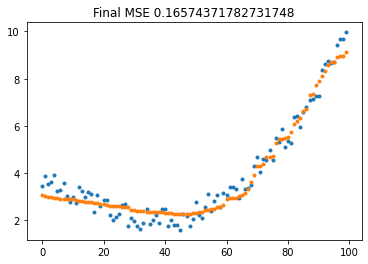

In [ ]:
def TEST_neural_network():
    
    def nonlinear_data(m=100):
        rng = np.random.RandomState(42)
        X = np.sort(6 * rng.rand(m, 1) - 3, axis=0)

        y = (2 + .5* X**2 + X) + rng.rand(m, 1)

        return X, y.reshape(-1, 1)
    
    nn = NeuralNetwork(
        alpha=.1,
        hidden_neurons=20,
        g_hidden=Sigmoid,
        g_output=Linear,
        batch_size=64, 
        epochs=500
    )
    
    X, y = nonlinear_data()
    nn.fit(X, y)
    
    y_hat = nn.predict(X)
    mse_ = mse(y=y, y_hat=y_hat)

    plt.plot(y, '.')
    plt.plot(y_hat, '.')
    plt.title(f"Final MSE {mse_}")
    
    todo_check([
        (np.isclose(mse_, .165, rtol=.1), "mse_ value is incorrect")
    ])
    
TEST_neural_network()
garbage_collect(['TEST_neural_network'])

# Non-linear Regression

Now it's time to apply our neural network implementation to the Forest Fire dataset.

## Training


#### TODO 19
Let's try training our `NeuralNetwork` class. The goal for the this TODO will be to get your validation MSE below 2. To do so, you'll have to manually tune the hyper-parameters such as the number of hidden units `hidden_neurons`, which activation function you'll use for `g_hidden` (`Sigmoid` or `Tanh`), the learning rate `alpha`, the size of the mini-batches `batch_size`, and the number of epochs `epochs`.

1. Call the `data_prep()` so that it will return the Forest Fire regression data formatted as NumPy arrays. Do so by passing the arguments which correspond to the following:
    1. Pass any required arguments (i.e., arguments with no default values).
    1. Return all data as NumPy arrays.


2. Create an instance of the `NeuralNetwork` class. Store the output into `nn`. In order to pass the TODO check you will need to tune the hyper-parameters (i.e., arguments passed to the  `NeuralNetwork` class) such that you get a validation MSE score below 2. Thus, you need to determine which arguments to pass to the `NeuralNetwork` class. The only argument that should remain static is the `g_output` argument. Recall, this will always need to be set to the `Linear` class for regression problems.
    1. Hint: Use the learning curve plot that is plotted at the end of the training to help select how many epochs you need. Refer to this [post](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/) or last weeks lab on how to interpret the training and validation learning curves.

Epoch: 1
	 Train MSE: 3.242446441146515
	 Valid MSE: 2.54129504447874
Epoch: 2
	 Train MSE: 2.7961499096926365
	 Valid MSE: 2.3267845012189143
Epoch: 3
	 Train MSE: 2.6078485371376927
	 Valid MSE: 2.1505453538966135
Epoch: 4
	 Train MSE: 2.4517303120039573
	 Valid MSE: 2.064424620216829
Epoch: 5
	 Train MSE: 2.3729209206069397
	 Valid MSE: 2.02265274335597
Epoch: 6
	 Train MSE: 2.333844615796963
	 Valid MSE: 2.000011131735529
Epoch: 7
	 Train MSE: 2.308488694351021
	 Valid MSE: 1.9862267512695515
Epoch: 8
	 Train MSE: 2.2934253369240047
	 Valid MSE: 1.9814487886204626
Epoch: 9
	 Train MSE: 2.286436391715704
	 Valid MSE: 1.9813035419948966
Epoch: 10
	 Train MSE: 2.2824378733762343
	 Valid MSE: 1.9782896835319725
Epoch: 11
	 Train MSE: 2.2767287730865546
	 Valid MSE: 1.9773851637691513
Epoch: 12
	 Train MSE: 2.271479989139912
	 Valid MSE: 1.9754454591006592
Epoch: 13
	 Train MSE: 2.26842470545601
	 Valid MSE: 1.9754503820338036
Epoch: 14
	 Train MSE: 2.2634602614796306
	 Valid MSE: 1.974

	 Train MSE: 1.9909776743741625
	 Valid MSE: 1.9235814800208293
Epoch: 127
	 Train MSE: 1.9878298734835025
	 Valid MSE: 1.9238042732856213
Epoch: 128
	 Train MSE: 1.9873274281013957
	 Valid MSE: 1.9233251717834925
Epoch: 129
	 Train MSE: 1.9846958562927708
	 Valid MSE: 1.925312918953067
Epoch: 130
	 Train MSE: 1.9840243296406745
	 Valid MSE: 1.9257594035744685
Epoch: 131
	 Train MSE: 1.982662148341874
	 Valid MSE: 1.9243607020280844
Epoch: 132
	 Train MSE: 1.9791850446364063
	 Valid MSE: 1.9233382353301816
Epoch: 133
	 Train MSE: 1.9798843993229536
	 Valid MSE: 1.9232672079961426
Epoch: 134
	 Train MSE: 1.9768185109015188
	 Valid MSE: 1.9232786896208047
Epoch: 135
	 Train MSE: 1.9763538456043062
	 Valid MSE: 1.9251686715169982
Epoch: 136
	 Train MSE: 1.9765050334104683
	 Valid MSE: 1.9262566379262
Epoch: 137
	 Train MSE: 1.9740394489507445
	 Valid MSE: 1.9242072518238653
Epoch: 138
	 Train MSE: 1.971842389065263
	 Valid MSE: 1.9249599483003896
Epoch: 139
	 Train MSE: 1.971055585590781


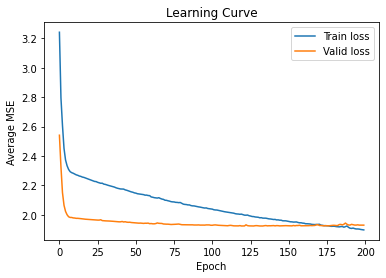

--------------------------------------------------
Valid MSE score: 1.9290456652992303
Your code PASSED the code check!


In [ ]:
# TODO 19.1
data = 
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data

# TODO 19.2
nn =
    
nn.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld)
vld_mse = mse(y_vld, nn.predict(X_vld))

print("-"*50)
plt.plot(nn.epoch_losses, label='Train loss')
plt.plot(nn.vld_epoch_losses, label='Valid loss')
plt.title("Learning Curve")
plt.ylabel("Average MSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()


print("-"*50)
print(f"Valid MSE score: {vld_mse}")
todo_check([
    (vld_mse < 1.97, "vld_mse was not less than 1.97")
])

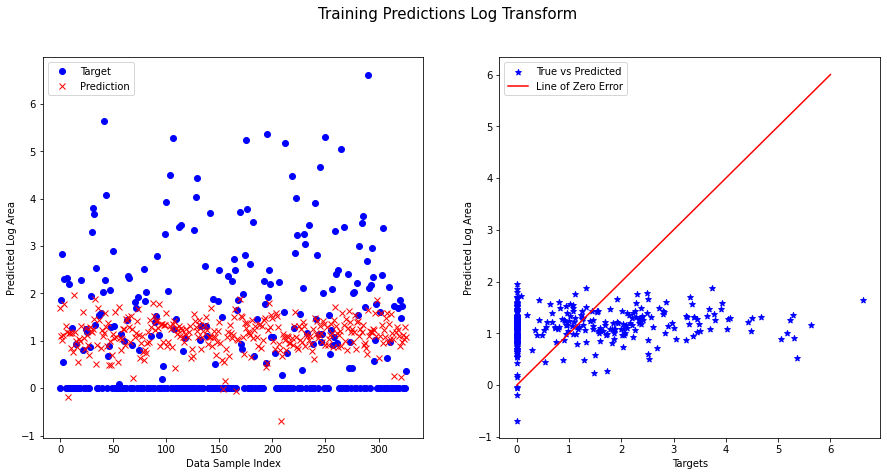

Training MSE: 1.8956773508383353
Training RMSE: 1.3768359927160299
Training SSE: 619.8864937241357

Training unlogged MSE: 5.65705604032488 ha
Training unlogged RMSE: 2.9623448850799217 ha


In [ ]:
y_hat_trn = nn.predict(X_trn)

trn_sse, trn_mse, trn_rmse = analyze(y_trn, y_hat_trn,
                                        title="Training Predictions Log Transform",
                                        dataset="Training",
                                        xlabel="Data Sample Index",
                                        ylabel="Predicted Log Area");


### Validation evaluation 

Use the below code to visualize the results for your validation data.

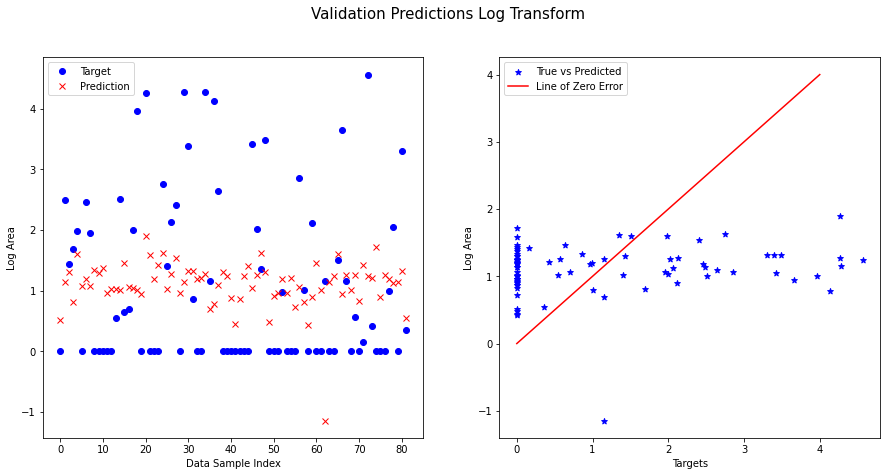

Validation MSE: 1.9290456652992303
Validation RMSE: 1.3889008839003705
Validation SSE: 158.1817445545369

Validation unlogged MSE: 5.882938479215651 ha
Validation unlogged RMSE: 3.0104396908573694 ha


In [ ]:
y_hat_vld = nn.predict(X_vld)

analyze(y_vld, y_hat_vld,
        title="Validation Predictions Log Transform",
        dataset="Validation",
        xlabel="Data Sample Index",
        ylabel="Log Area");


### Testing evaluation

Use the below code to visualize the results for your testing data. Depending on your hyper-parameter fine tuning, you should notice that, for the most part, performance is on par or slightly worse than the linear regression and polynomial regression algorithms which achieved around ~1.4 RMSE. 

Once again, this is most likely because we need more data and possibly better features to solve this problem. Keep in mind, neural networks aren't a golden bullet. Meaning, they aren't the best algorithm for every problem (hence recall back to the [no free lunch theorem](https://machinelearningmastery.com/no-free-lunch-theorem-for-machine-learning/)). As we'll see in the near future, deep learning can be quite powerful but even it too has its limitations.

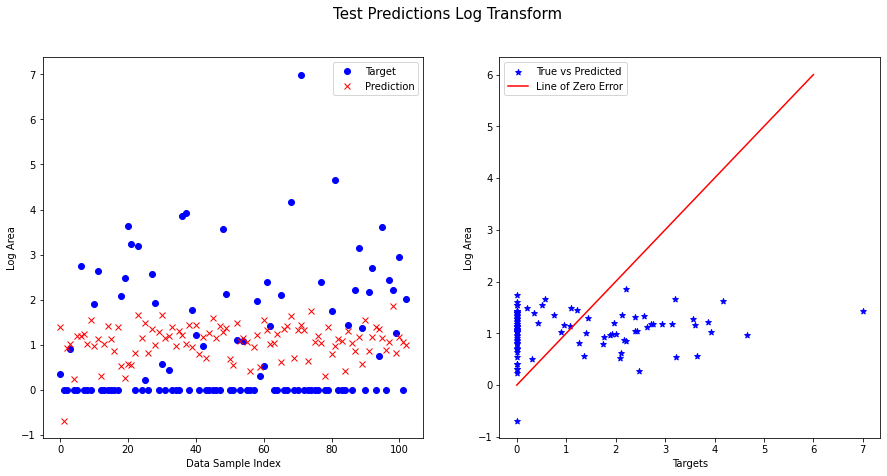

Test MSE: 2.0500357758912258
Test RMSE: 1.4317945997562729
Test SSE: 211.15368491679627

Test unlogged MSE: 6.768179014862987 ha
Test unlogged RMSE: 3.186205017436497 ha


In [ ]:
y_hat_tst = nn.predict(X_tst)

analyze(y_tst, y_hat_tst,
        title="Test Predictions Log Transform",
        dataset="Test",
        xlabel="Data Sample Index",
        ylabel="Log Area");
